<a href="https://colab.research.google.com/github/FeryET/DeepLearning_CA7/blob/master/DL_CA7_Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Wed Jun  9 15:56:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Downloading requirements

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle"
!kaggle datasets download -d adityajn105/flickr8k
!unzip -qo "/content/flickr8k.zip"

Mounted at /content/drive
 99% 1.03G/1.04G [00:17<00:00, 60.2MB/s]
100% 1.04G/1.04G [00:18<00:00, 61.7MB/s]


In [ ]:
import gc
import io
import os 
from glob import glob
import shutil

import itertools
import collections
import string 
import json
from PIL import Image
import re
import textwrap 

import h5py
import numpy as np
import pandas as pd




from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms


import gensim.downloader as api


from pathlib import Path


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Matplotlib
plt.rc('font', family='serif')
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 2

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.rcParams['legend.title_fontsize'] = 'xx-small'

# Defining Constants

In [ ]:
# Locations
IMAGE_ROOT = "/content/Images"
CAPTION_CSV_LOC = "/content/captions.txt"
SAVE_LOCATION = "/content/drive/MyDrive/Academics/Courses/Deep Learning/CA3/Q1/"
# if os.path.isdir(SAVE_LOCATION):
  # shutil.rmtree(SAVE_LOCATION)
Path(SAVE_LOCATION).mkdir(parents=True, exist_ok=True) # Create SAVE_LOCATION 



# Tokens
START_TOKEN = "<SOS>"
END_TOKEN = "<EOS>"
PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"

# Captions related
MAX_LENGTH = 30 
LSTM_HIDDEN_SIZE = 256 # LSTM units?
MIN_WORD_FREQ = 10
EMBEDDING_DIM = 300
CAPTIONS_PER_IMAGE = 5
MIN_WORD_LENGTH = 2


# Dataset specifics
TEST_SPLIT = 0.1


# LEARNING PARAMS
k = 1
MAX_EPOCHS = 100
TRAIN_BATCH_SIZE = 256
TEST_BATCH_SIZE = 512
LR = 5e-4
WD = 0
EARLY_STOPPING_START_EPOCH = 50
EARLY_STOPPING_PATIENCE = 5

# Processing Documents

### Preprocessing Captions

In [ ]:
def preprocess_text(text):
  prep = text.lower()
  # remove whitespace, numerics and punctuations and replace them with space
  prep = re.sub("(\s+)|(\d+)|([^\w\s]+)", " ", prep)
  prep = prep.split()
  prep = [p for p in prep if len(p) >= MIN_WORD_LENGTH]
  return prep

caption_df = pd.read_csv(CAPTION_CSV_LOC)
caption_df.sort_values(by="image", inplace=True)
caption_df["cleaned"] = caption_df["caption"].apply(preprocess_text)

### Creating Vocabulary

In [ ]:
counter = collections.Counter(itertools.chain(*caption_df["cleaned"]))
words = sorted([v for v, n in counter.items() if n > MIN_WORD_FREQ])
words = [PAD_TOKEN, START_TOKEN, END_TOKEN, UNK_TOKEN] + words
vocab = {w: idx for idx, w in enumerate(words)}
id2word = {idx: w for idx, w in enumerate(words)}
print(f"Vocabulary Length: {len(vocab)}")

Vocabulary Length: 1849


### Defining Transforms for Captions

In [ ]:
# Transforms
class VocabTransform:
  def __init__(self, vocab):
    self.vocab = vocab
  
  def __call__(self, tokenized):
    return [self.vocab[t] if t in self.vocab.keys() else self.vocab[UNK_TOKEN] for t in tokenized]

class CaptionConditioner:
  def __init__(self, max_length=MAX_LENGTH):
    self.max_length = max_length
  
  def __call__(self, tokenized):
    return [START_TOKEN] + tokenized[:self.max_length - 2] + [END_TOKEN]

class TextIndicesToTensor:
  def __call__(self, item):
    return torch.tensor(tuple(item), dtype=torch.int64)


caption_transforms = transforms.Compose(
    [
     CaptionConditioner(),
     VocabTransform(vocab),
     TextIndicesToTensor(),
    ]
)

### Images

In [ ]:
# This is copied from https://pytorch.org/hub/pytorch_vision_resnet/
image_mean = [0.485, 0.456, 0.406]
image_std = [0.229, 0.224, 0.225]

image_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224), # As an augmenting process
    transforms.ToTensor(),
    transforms.Normalize(mean=image_mean, std=image_std),
])

image_mean = np.array(image_mean)
image_std = np.array(image_std)

# Defining the Dataset

In [ ]:
class FlickrDataset(Dataset):
  def __init__(self, 
               images_path, 
               caption_df, 
               image_transforms, 
               caption_transforms,
               preload=True,
               captions_per_image=CAPTIONS_PER_IMAGE):
    self.images_path = images_path
    self.images_fnames = sorted(os.listdir(images_path))
    self.data = caption_df.to_dict(orient="records")
    self.captions_per_image = captions_per_image
    self.no_transform = False
    self.no_augment = False
    self.image_transforms = image_transforms
    self.caption_transforms = caption_transforms
    self.preload = preload
    if self.preload:
      self._preload_images()

  def __len__(self):
    return len(self.data)


  def _preload_images(self):
    # Preloading images into an HDF5 dataset
    self.image_hdf5_path = "images.hdf5"
    self.hfile_pack_tag = "pack_{}"
    self.hfile_image_tag = "image_{}"
    self.hfile_paths = []
    if os.path.exists(self.image_hdf5_path):
      os.remove(self.image_hdf5_path)
    hf = h5py.File(self.image_hdf5_path, 
                   'a', 
                   rdcc_nbytes=1024**2*2000, #2 GB of cache
                   rdcc_nslots=1e7)
    # creating groups
    group_labels = [self.hfile_pack_tag.format(idx) for idx in \
                     sorted(set(np.arange(len(self.images_fnames)) // 100))]
    groups = [hf.create_group(label) for label in group_labels]
    for idx in trange(len(self)//self.captions_per_image, desc="creating dataset"):
      grp = groups[idx//100]
      label = group_labels[idx//100]
      fname = self.data[idx * self.captions_per_image]["image"]
      fpath = os.path.join(self.images_path, fname)
      image = Image.open(fpath)
      image = self.image_transforms(image).cpu().numpy()
      image_id = self.hfile_image_tag.format(idx % 100)
      grp.create_dataset(image_id, data=image)
      self.hfile_paths.append(
          f"{label}/{image_id}"
      )
    hf.close()
    self.hf = h5py.File(self.image_hdf5_path, 'r')
    
        
    

  def __getitem__(self, idx):
    
    if self.preload:
      # Load from HDF5
      image_idx = idx // self.captions_per_image
      path = self.hfile_paths[image_idx]
      image = np.array(self.hf[path])
      image = torch.FloatTensor(image)
    else:
      # Load from disk
      fname = self.data[idx]["image"]
      fpath = os.path.join(self.images_path, fname)
      image = Image.open(fpath)
      if not self.no_transform:
        image = self.image_transforms(image)
    
    # Load captions
    caption = self.data[idx]["cleaned"]
    if not self.no_transform:
      caption = self.caption_transforms(caption)
      caption_length = list(caption.size())[0]
    else:
      caption_length = None
      
    return image, caption, caption_length

  
  # Creating splitted datasets, because of the repeated captions
  def generate_train_test_indices(self, split=0.1, seed=None):
    indices = np.arange(len(self) // self.captions_per_image) * self.captions_per_image

    if seed is None:
      np.random.shuffle(indices)
    else:
      random_state = np.random.RandomState(seed)
      random_state.shuffle(indices)

    indice_split_index = int(len(indices) * (1 - split))
    train_indices, test_indices = indices[:indice_split_index], indices[indice_split_index:]

    train_indices = [range(x,x+self.captions_per_image) for x in train_indices]
    test_indices = [range(x,x+self.captions_per_image) for x in test_indices]

    train_indices = [x for pack in train_indices for x in pack]
    test_indices = [x for pack in test_indices for x in pack]
  

    return train_indices, test_indices

  def __exit__(self, exc_type, exc_value, traceback):
     if self.preload:
       self.hf.close()

# Defining the Network

### A useful module

In [ ]:
class PackedLinear(nn.Module):
  def __init__(self, input_size, output_size, n_pack):
    super().__init__()

    self.n_pack = n_pack
    self.input_size = input_size
    self.output_size = output_size

    self.fcs = nn.ModuleList([
                nn.Linear(input_size, output_size) for i in range(n_pack)
              ])
  
  def forward(self, X):
    batch_size, seq_len, _ = X.size()
    X = X.view(batch_size, seq_len, self.n_pack, self.input_size)   
    X = X.permute(0, 1, 3, 2) # LSTM needs this
    outputs = [self.fcs[i](X[..., i]) for i in range(self.n_pack)]
    outputs = torch.stack(outputs, dim=-2)
    return outputs

In [ ]:

# Influenced by https://github.com/siddsrivastava/Image-captioning/blob/master/model.py

class FlickrEncoderCNN(nn.Module):
  def __init__(self, 
               embedding_dim, 
               freeze):
    super().__init__()
    # Loading resnet
    resnet = torchvision.models.resnet18(pretrained=True)
    fc_in_features = resnet.fc.in_features

    # Defining layers
    modules = list(resnet.children())[:-1]
    self.resnet = nn.Sequential(*modules)
    self.fc = nn.Linear(fc_in_features, embedding_dim)

    # Freezing if needed
    if freeze:
      for param in self.resnet.parameters():
          param.requires_grad = False
    for param in self.fc.parameters():
      param.requires_grad = True
    
    self.modules = nn.ModuleList(
        [self.resnet, self.fc]
    )  
  def forward(self, x):
    x = self.resnet(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x


### TODO: ADD PACK PADDED SEQUENCE
class FlickrDecoderLSTM(nn.Module):
  def __init__(self, 
                vocab_size,
                embedding_dim,
                hidden_size,
                padding_idx,
                bidirectional=False,
                dropout=0):
    
    super().__init__()
    # Creating embeddings
    self.embed = nn.Embedding(num_embeddings=vocab_size,
                              embedding_dim=embedding_dim, 
                              padding_idx=padding_idx,
                              sparse=False,
                              )
    # self.embed = nn.Embedding.from_pretrained(
    #     torch.FloatTensor(glove_embedding))
    self.padding_idx = padding_idx

    self.lstm = nn.LSTM(input_size=embedding_dim,
                        hidden_size=hidden_size,
                        batch_first=True,
                        dropout=dropout,
                        bidirectional=bidirectional)
    
    self.bidirectional = bidirectional
    self.num_directions = 2 if bidirectional else 1
    self.linear_input_size  = hidden_size
    if bidirectional:
      self.fc = PackedLinear(input_size=hidden_size, 
                             output_size=vocab_size, 
                             n_pack=self.num_directions)
    else:
      self.fc = nn.Linear(self.linear_input_size, vocab_size )

    self.modules = nn.ModuleList(
        [self.embed, self.lstm, self.fc]
    )


  def forward(self, features, caption_seqs, caption_lengths=None,hidden=None):
      batch_size, seq_len = caption_seqs.size()

      if hidden is None:
        hidden_shape = (self.num_directions, batch_size, self.lstm.hidden_size)
        h0 = torch.zeros(hidden_shape).to(device)
        c0 = torch.zeros(hidden_shape).to(device)
        hidden = (h0, c0)

      caption_seqs = caption_seqs[:,:-1] # from 1 to the n-1

      embeddings = self.embed(caption_seqs)

      # Add the image feature to the start of the sequence
      lstm_input = torch.cat((features.unsqueeze(1), embeddings), dim=1).contiguous()
      lstm_input = nn.utils.rnn.pack_padded_sequence(lstm_input, 
                                                      caption_lengths, 
                                                      batch_first=True,
                                                      enforce_sorted=False)


      lstm_out, hidden = self.lstm(lstm_input, hidden)
      
      lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, 
                                                  batch_first=True, 
                                                  padding_value=self.padding_idx)
      
      outputs = self.fc(lstm_out)
      return outputs, hidden


class FlickrNet(nn.Module):
  def __init__(self, 
               vocab_size,
               embedding_dim,
               hidden_size,
               padding_idx,
               start_token_index,
               end_token_index,
               unk_token_index,
               bidirectional=False,
               dropout=0,
               freeze=True):
    super().__init__()

    self.vocab_size = vocab_size
    encoder = FlickrEncoderCNN(embedding_dim, freeze)
    decoder = FlickrDecoderLSTM(vocab_size, 
                                    embedding_dim, 
                                    hidden_size, 
                                    padding_idx, 
                                    bidirectional, 
                                    dropout)
    self.encoder = encoder
    self.decoder = decoder
    self.bidirectional = bidirectional
    
    self.modules = nn.ModuleList([encoder,decoder])

    self.start_token_index = start_token_index
    self.end_token_index = end_token_index
    self.unk_token_index = unk_token_index
    self.pad_token_index = padding_idx

    self.loss_fn = nn.CrossEntropyLoss()

  def forward(self, images, caption_seqs, caption_lengths):
    features = self.encoder(images)
    outputs, hiddens = self.decoder(features, caption_seqs, caption_lengths)
    return outputs
  
  def loss(self, logits, targets):



        # flatten all the targets
        targets = targets.view(-1)
        # padding token should not contribute to our predictions 
        # because we didn't generate it via network
        mask = targets != self.pad_token_index
        targets = targets[mask]
          
        if self.bidirectional:
          forward_index, backward_index = 0, 1

          forward_logits = logits[..., forward_index, :].view(-1, self.vocab_size)
          forward_logits = forward_logits[mask, ...]

          forward_loss = self.loss_fn(forward_logits, targets)

          backward_logits = logits[..., backward_index, :].view(-1, self.vocab_size)
          backward_logits = backward_logits[mask, ...]

          backward_loss = self.loss_fn(backward_logits, targets)

          loss = forward_loss + backward_loss

        else:
          # flatten all logits
          logits = logits.view(-1, self.vocab_size)

          logits = logits[mask, ...]

          loss = self.loss_fn(logits, targets)


        numel = targets.numel()

        return loss, numel

  def predict(self, image, max_len = 30):
      inputs = self.encoder(image).unsqueeze(1)
      if self.bidirectional:
        return self._predict_bidirectional(inputs, max_len)
      else:
        return self._predict_unidirectional(inputs, max_len)
      
    
  def _predict_unidirectional(self, inputs, max_len=30):
      output = []
      hidden = None
      for i in range(max_len):
        lstm_out, hidden = self.decoder.lstm(inputs, hidden)
        output_vocab = self.decoder.fc(lstm_out).squeeze()
        output_vocab = F.softmax(output_vocab, dim=-1).detach().cpu().numpy()
        words_indices = output_vocab.argsort(axis=-1)[::-1] # reversing the argsort
        words_indices = words_indices[words_indices != self.pad_token_index].ravel()
        i = 0
        if int(words_indices[i]) == self.unk_token_index:
            i += 1
        word = int(words_indices[i])
        output.append(word)
        if word == self.end_token_index:
          break  
        inputs = self.decoder.embed(torch.LongTensor([[word]]).to(device))
      return output

  def _predict_bidirectional(self, features, max_len=30):
      def compute_total_prob(prob_list):
        indexes = np.arange(len(prob_list))
        total_prob = 0
        for i in indexes[::-1]:
          prob_i = 1
          for j in indexes[:i]:
            prob_i *= prob_list[j]
          total_prob += prob_i
        return total_prob

      def get_word(inputs, hidden, pass_index):
        lstm_out, hidden = self.decoder.lstm(inputs, hidden)
        output_vocab = self.decoder.fc(lstm_out).squeeze()[pass_index, ...]
        output_vocab = F.softmax(output_vocab, dim=-1).detach().cpu().numpy()
        words_indices = output_vocab.argsort(axis=-1)[::-1] # reversing the argsort
        words_indices = words_indices[words_indices != self.pad_token_index].ravel()
        i = 0
        if int(words_indices[i]) == self.unk_token_index:
            i += 1
        word = int(words_indices[i])
        prob = output_vocab[word]
        end_flag = False
        if word == self.end_token_index:
            end_flag = True
        inputs = self.decoder.embed(torch.LongTensor([[word]]).to(device))
        return word, prob, inputs, hidden, end_flag

      forward_words = []
      backward_words = []
      forward_probs = []
      backward_probs = []

      forward_ended = False
      backward_ended = False

      f_hidden, b_hidden = None, None

      f_inputs, b_inputs = features, features

      for i in range(max_len):
        if forward_ended is not True:
          f_word, f_prob, f_inputs, f_hidden, forward_ended = get_word(f_inputs, f_hidden, 0)
          forward_words.append(f_word)
          forward_probs.append(f_prob)
        
        if backward_ended is not True:
          b_word, b_prob, b_inputs, b_hidden, backward_ended = get_word(b_inputs, b_hidden, 0)
          backward_words.append(b_word)
          backward_probs.append(b_prob)
        if forward_ended and backward_ended:
          break
      
      p_forward = compute_total_prob(forward_probs)
      p_backward = compute_total_prob(backward_probs)

      if p_forward > p_backward:
        output = forward_words
      else:
        output = backward_words

      return output

In [ ]:
class PadCaptions:
  def __init__(self, vocab):
    self.pad_idx = vocab[PAD_TOKEN]
  
  def __call__(self, batch):
    images, captions, caption_lengths = list(zip(*batch))
    captions = torch.nn.utils.rnn.pad_sequence(captions,
                                    batch_first=True,
                                    padding_value=self.pad_idx).detach()
    images = torch.stack(images, dim=0).detach()
    return images, captions, caption_lengths

batch_transforms = transforms.Compose([
     PadCaptions(vocab),
     ]
)

In [ ]:
# From here: https://debuggercafe.com/using-learning-rate-scheduler-and-early-stopping-with-pytorch/
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0, start_epoch=20):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.start_epoch = start_epoch
    def __call__(self, val_loss, epoch):
      if epoch < self.start_epoch:
        self.best_loss = val_loss
        return
      if self.best_loss == None:
          self.best_loss = val_loss
      elif self.best_loss - val_loss > self.min_delta:
          self.best_loss = val_loss
          
      elif self.best_loss - val_loss < self.min_delta:
          self.counter += 1
          print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
          if self.counter >= self.patience:
              print('INFO: Early stopping')
              self.early_stop = True

# Preparing for Training

### Defining training and testing functions

In [ ]:
def generate_sentence(model, n = 2):
    print("#########################")  
    nums = np.random.randint(0, len(test_dataset), size=(n,))
    for i in nums:
      image, captions, _ = test_dataset[i]
      image = image.unsqueeze(0).to(device)
      gen = model.predict(image)
      gen = " ".join([id2word[g] for g in gen])
      caption = " ".join([id2word[c] for c in captions.numpy()])
      print(f"### Original: {caption}")
      print(f"### Generated: {gen}")
    print("#########################")
    
def test(model, test_loader):
  test_loss = 0
  n_items = 0
  with torch.no_grad():
    model.eval()
    for batch in test_loader:
        images, captions, caption_lengths = batch
        images, captions = images.to(device), captions.to(device)

        outputs = model(images, captions, caption_lengths=caption_lengths)
        loss, numel = model.loss(outputs, captions)
      
        test_loss += loss.item() * numel
        n_items += numel
  
  
  del images, captions, outputs, loss
  torch.cuda.empty_cache() 
  gc.collect()
      
  test_loss /= n_items
  return test_loss

def train(model, 
          optimizer, 
          train_loader, 
          test_loader, 
          model_name, 
          dataset, 
          early_stopping_patience=5,
          early_stopping_start_epoch=20,
          max_epochs=50):
  gpu = device.type == "cuda"
  if gpu:
    scaler = torch.cuda.amp.GradScaler()
  info = []
  # early_stopper = EarlyStopping(patience=early_stopping_patience, 
                                # start_epoch=early_stopping_start_epoch)
  for epoch in range(1, max_epochs+1):
    model.train()
    train_loss = 0
    n_items = 0
    pbar = tqdm(total=len(train_loader), desc=f"Epoch: {epoch}", leave=False)
    for batch in train_loader:
      # Emptying gradients before starting to train
      optimizer.zero_grad()

      images, captions, caption_lengths = batch
      images, captions = images.to(device), captions.to(device)
      
      if gpu:
        with torch.cuda.amp.autocast():
          outputs = model(images, captions, caption_lengths=caption_lengths)
          loss, numel = model.loss(outputs, captions)
          

        # scaling the loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
      else:
        outputs = model(images, captions)
        loss, numel = model.loss(outputs, captions)
        loss.backward()
        optimizer.step()
      
      # computing the running loss
      train_loss += loss.item() * numel
      n_items += numel

      # updating the progress bar
      pbar.set_postfix(batch_loss=f"{loss.item():.3f}")
      pbar.update()

      del images, captions, outputs, loss

    torch.cuda.empty_cache() 
    gc.collect()

    pbar.close()
    train_loss /= n_items
    info.append(
        {"epoch": epoch, "train_loss": train_loss}
    )
    print(f"Epoch: {epoch}\t Train Loss: {train_loss:.3f}")
    if epoch % 5 == 0:
      generate_sentence(model)
      torch.save(model.state_dict(), 
                 os.path.join(SAVE_LOCATION, f"{model_name}.model")
                 )
    
    with open(os.path.join(SAVE_LOCATION, f"{model_name}.json"), "w") as jfile:
      json.dump(info, jfile)
    
    # Early stopping
    # early_stopper(test_loss, epoch)
    # if early_stopper.early_stop:
      # break
  return info

### Creating Dataset and DataLoader

In [ ]:
dataset = FlickrDataset(
    images_path=IMAGE_ROOT, 
    caption_df=caption_df,
    image_transforms=image_transforms, 
    caption_transforms=caption_transforms
)

train_indices, test_indices = dataset.generate_train_test_indices(split=0.1, seed=42)
print(len(train_indices), len(test_indices))

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

print(np.intersect1d(train_indices, test_indices))

36405 4050
[]


In [ ]:
train_loader_params ={
    'batch_size': TRAIN_BATCH_SIZE, 
    'shuffle': True, 
    'num_workers': 2, 
    'collate_fn': batch_transforms, 
    'prefetch_factor': 4
}

test_loader_params = {
    'batch_size': TEST_BATCH_SIZE, 
    'shuffle': False, 
    'num_workers': 0, 
    'collate_fn': batch_transforms, 
}

train_loader = DataLoader(train_dataset, 
                          **train_loader_params)

test_loader = DataLoader(test_dataset, 
                         **test_loader_params)

In [ ]:
# Set the tqdm text color to white.

from IPython.display import HTML, display

def set_css_in_cell_output():
    display(HTML('''
        <style>
            .jupyter-widgets {color: #d5d5d5 !important;}
            .widget-label {color: #d5d5d5 !important;}
        </style>
    '''))

get_ipython().events.register('pre_run_cell', set_css_in_cell_output)

# Creating models and training



In [ ]:
train_info = {}
model_params = {}

## Part A

In [ ]:
label = "part_a"

model_params[label] = dict(
    vocab_size=len(vocab),
    embedding_dim=EMBEDDING_DIM,
    hidden_size=LSTM_HIDDEN_SIZE,
    padding_idx=vocab[PAD_TOKEN],
    start_token_index=vocab[START_TOKEN],
    end_token_index=vocab[END_TOKEN],           
    unk_token_index=vocab[UNK_TOKEN],
    bidirectional=False,
    dropout=0,
    freeze=True
    )

model = FlickrNet(**model_params[label]).to(device)

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params_a = sum([np.prod(p.size()) for p in model_parameters])
print(f"Number of parameters for part a: {params_a:.2E}")



optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)



Number of parameters for part a: 1.76E+06


In [ ]:
label = "part_a"
train_info[label] = train(model, 
                    optimizer, 
                    train_loader, 
                    test_loader, 
                    label,
                    dataset=dataset,
                    early_stopping_start_epoch=EARLY_STOPPING_START_EPOCH,
                    early_stopping_patience=EARLY_STOPPING_PATIENCE,
                    max_epochs=MAX_EPOCHS)

Epoch: 1	 Train Loss: 5.316


Epoch: 2	 Train Loss: 4.194


Epoch: 3	 Train Loss: 3.830


Epoch: 4	 Train Loss: 3.610


Epoch: 5	 Train Loss: 3.454
#########################
### Original: <SOS> dogs playing on the dirt path <EOS>
### Generated: <SOS> man in blue shirt is standing on the beach <EOS>
### Original: <SOS> large black dog and small brown dog are playing in the house <EOS>
### Generated: <SOS> man in blue shirt is standing on the beach <EOS>
#########################


Epoch: 6	 Train Loss: 3.334


Epoch: 7	 Train Loss: 3.243


Epoch: 8	 Train Loss: 3.166


Epoch: 9	 Train Loss: 3.098


Epoch: 10	 Train Loss: 3.037
#########################
### Original: <SOS> man shoots gun that <UNK> bright light <EOS>
### Generated: <SOS> man in black shirt and white shirt is standing on the street <EOS>
### Original: <SOS> elderly man in straw hat is sitting on bench <EOS>
### Generated: <SOS> man in black shirt and white shirt is standing on the street <EOS>
#########################


Epoch: 11	 Train Loss: 2.982


Epoch: 12	 Train Loss: 2.935


Epoch: 13	 Train Loss: 2.890


Epoch: 14	 Train Loss: 2.848


Epoch: 15	 Train Loss: 2.811
#########################
### Original: <SOS> person flies through the air while riding an off road vehicle on dirt road <EOS>
### Generated: <SOS> man in red shirt is standing on the street <EOS>
### Original: <SOS> the american footballer in yellow catches the ball whilst under <UNK> from the <UNK> in white <EOS>
### Generated: <SOS> man in red shirt is standing on the street <EOS>
#########################


Epoch: 16	 Train Loss: 2.776


Epoch: 17	 Train Loss: 2.742


Epoch: 18	 Train Loss: 2.708


Epoch: 19	 Train Loss: 2.679


Epoch: 20	 Train Loss: 2.650
#########################
### Original: <SOS> young smiling girl in hat crouched in field <EOS>
### Generated: <SOS> man in black shirt and jeans is standing in front of large crowd <EOS>
### Original: <SOS> woman in gray is smoking cigarette <EOS>
### Generated: <SOS> man in black shirt and jeans is standing in front of large crowd <EOS>
#########################


Epoch: 21	 Train Loss: 2.621


Epoch: 22	 Train Loss: 2.592


Epoch: 23	 Train Loss: 2.567


Epoch: 24	 Train Loss: 2.543


Epoch: 25	 Train Loss: 2.519
#########################
### Original: <SOS> three grey dogs jump at woman <EOS>
### Generated: <SOS> man in red shirt is riding bicycle in the park <EOS>
### Original: <SOS> black dog jumping out of the water with stick in his mouth <EOS>
### Generated: <SOS> man in red shirt is riding bicycle in the park <EOS>
#########################


Epoch: 26	 Train Loss: 2.494


Epoch: 27	 Train Loss: 2.470


Epoch: 28	 Train Loss: 2.447


Epoch: 29	 Train Loss: 2.428


Epoch: 30	 Train Loss: 2.406
#########################
### Original: <SOS> little boy kisses little girl on the side of the road <EOS>
### Generated: <SOS> man in red shirt is standing on rock with his arms in the air <EOS>
### Original: <SOS> many people on roller coaster ride are <UNK> upside down over white track <EOS>
### Generated: <SOS> man in red shirt is standing on rock in front of large crowd <EOS>
#########################


Epoch: 31	 Train Loss: 2.383


Epoch: 32	 Train Loss: 2.364


Epoch: 33	 Train Loss: 2.344


Epoch: 34	 Train Loss: 2.326


Epoch: 35	 Train Loss: 2.305
#########################
### Original: <SOS> black dog runs down snowy hill with his legs deep in the snow <EOS>
### Generated: <SOS> man in black shirt is sitting on bench in front of white building <EOS>
### Original: <SOS> girl in pink outfit and blue cap laughs <EOS>
### Generated: <SOS> man in black shirt is sitting on bench in front of white building <EOS>
#########################


Epoch: 36	 Train Loss: 2.288


Epoch: 37	 Train Loss: 2.267


Epoch: 38	 Train Loss: 2.249


Epoch: 39	 Train Loss: 2.230


Epoch: 40	 Train Loss: 2.212
#########################
### Original: <SOS> several women dancing <EOS>
### Generated: <SOS> man in blue shirt is standing on the sidewalk with his arms outstretched <EOS>
### Original: <SOS> <UNK> with picture of girl on it <EOS>
### Generated: <SOS> man in blue shirt is sitting on bench in front of white building <EOS>
#########################


Epoch: 41	 Train Loss: 2.193


Epoch: 42	 Train Loss: 2.178


Epoch: 43	 Train Loss: 2.160


Epoch: 44	 Train Loss: 2.140


Epoch: 45	 Train Loss: 2.124
#########################
### Original: <SOS> two children play soccer on green grass <EOS>
### Generated: <SOS> woman in blue shirt and jeans stands on the sidewalk next to man in front of building <EOS>
### Original: <SOS> girl basketball player wearing blue is blocking another girl player wearing yellow <EOS>
### Generated: <SOS> woman in blue shirt and jeans stands on the sidewalk next to man in black and white bag <EOS>
#########################


Epoch: 46	 Train Loss: 2.110


Epoch: 47	 Train Loss: 2.091


Epoch: 48	 Train Loss: 2.076


Epoch: 49	 Train Loss: 2.059


Epoch: 50	 Train Loss: 2.045
#########################
### Original: <SOS> woman carrying black and white dog on sidewalk in front of <UNK> parked cars <EOS>
### Generated: <SOS> woman in blue shirt and jeans stands on sidewalk <EOS>
### Original: <SOS> man stands on top of an elephant in the water <EOS>
### Generated: <SOS> woman in blue shirt and jeans stands on the sidewalk next to man in white and black <EOS>
#########################


Epoch: 51	 Train Loss: 2.026


Epoch: 52	 Train Loss: 2.012


Epoch: 53	 Train Loss: 1.996


Epoch: 54	 Train Loss: 1.982


Epoch: 55	 Train Loss: 1.971
#########################
### Original: <SOS> dog running outside <EOS>
### Generated: <SOS> woman in black and white shirt and jeans is sitting on bench <EOS>
### Original: <SOS> young boy is walking towards <UNK> on the shoreline of beach <EOS>
### Generated: <SOS> woman in black is sitting on bench in front of brick wall <EOS>
#########################


Epoch: 56	 Train Loss: 1.953


Epoch: 57	 Train Loss: 1.937


Epoch: 58	 Train Loss: 1.923


Epoch: 59	 Train Loss: 1.907


Epoch: 60	 Train Loss: 1.894
#########################
### Original: <SOS> brown dog holding huge stick in its mouth running in the snow <EOS>
### Generated: <SOS> woman is sitting on the edge of ledge that is on the water <EOS>
### Original: <SOS> person crouches at the end of dock on lake <EOS>
### Generated: <SOS> woman is sitting on the edge of ledge that is on the water <EOS>
#########################


Epoch: 61	 Train Loss: 1.881


Epoch: 62	 Train Loss: 1.865


Epoch: 63	 Train Loss: 1.852


Epoch: 64	 Train Loss: 1.839


Epoch: 65	 Train Loss: 1.825
#########################
### Original: <SOS> young woman standing above crowd <EOS>
### Generated: <SOS> woman is sitting on the edge of ledge and her shoes <EOS>
### Original: <SOS> two snowboarders in yellow and green are jumping in the air <EOS>
### Generated: <SOS> woman is sitting on bench with her arms in the air while her friend watches <EOS>
#########################


Epoch: 66	 Train Loss: 1.813


Epoch: 67	 Train Loss: 1.798


Epoch: 68	 Train Loss: 1.784


Epoch: 69	 Train Loss: 1.771


Epoch: 70	 Train Loss: 1.760
#########################
### Original: <SOS> brown dog carrying stick <EOS>
### Generated: <SOS> woman is sitting on the edge of cement ledge and is sitting on the water <EOS>
### Original: <SOS> man in swimming trunks walking down to his <UNK> that are <UNK> on yellow canoe <EOS>
### Generated: <SOS> woman is sitting on the edge of cement ledge and is sitting on the water <EOS>
#########################


Epoch: 71	 Train Loss: 1.746


Epoch: 72	 Train Loss: 1.733


Epoch: 73	 Train Loss: 1.721


Epoch: 74	 Train Loss: 1.707


Epoch: 75	 Train Loss: 1.696
#########################
### Original: <SOS> small dog lands on big dog trying to get disc <EOS>
### Generated: <SOS> man with his arm around baby sitting on bed with woman <EOS>
### Original: <SOS> boy is swimming underwater holding toy in his hand <EOS>
### Generated: <SOS> man with his arm around baby sitting on bed with woman <EOS>
#########################


Epoch: 76	 Train Loss: 1.685


Epoch: 77	 Train Loss: 1.673


Epoch: 78	 Train Loss: 1.663


Epoch: 79	 Train Loss: 1.649


Epoch: 80	 Train Loss: 1.638
#########################
### Original: <SOS> black and grey dog catches tennis ball at the beach <EOS>
### Generated: <SOS> woman is sitting on bench <EOS>
### Original: <SOS> cyclist is leaning his bicycle up on its front wheel <EOS>
### Generated: <SOS> woman is sitting on bench with her arms in the air while her dog watches <EOS>
#########################


Epoch: 81	 Train Loss: 1.631


Epoch: 82	 Train Loss: 1.618


Epoch: 83	 Train Loss: 1.605


Epoch: 84	 Train Loss: 1.596


Epoch: 85	 Train Loss: 1.586
#########################
### Original: <SOS> woman wearing red costume plays an instrument against brick wall <EOS>
### Generated: <SOS> man is sitting on bench and woman in front of an art gallery <EOS>
### Original: <SOS> kids playing in tub of plastic balls <EOS>
### Generated: <SOS> man is sitting on the ground and leans against the wall <EOS>
#########################


Epoch: 86	 Train Loss: 1.576


Epoch: 87	 Train Loss: 1.566


Epoch: 88	 Train Loss: 1.555


Epoch: 89	 Train Loss: 1.547


Epoch: 90	 Train Loss: 1.534
#########################
### Original: <SOS> two blond women in <UNK> beer shirts walk outside <EOS>
### Generated: <SOS> woman is sitting on bench in front of cow statue <EOS>
### Original: <SOS> two children carry flowers as they walk along grassy track <EOS>
### Generated: <SOS> woman is sitting on bench in front of statue <EOS>
#########################


Epoch: 91	 Train Loss: 1.524


Epoch: 92	 Train Loss: 1.512


Epoch: 93	 Train Loss: 1.507


Epoch: 94	 Train Loss: 1.496


Epoch: 95	 Train Loss: 1.484
#########################
### Original: <SOS> man in black jacket is beside the window of coffee shop looking down <EOS>
### Generated: <SOS> young boy is sitting at table with laptop and paper on his hands <EOS>
### Original: <SOS> dog fetching huge stick <EOS>
### Generated: <SOS> man is sitting on bench and woman in red shirt <EOS>
#########################


Epoch: 96	 Train Loss: 1.474


Epoch: 97	 Train Loss: 1.465


Epoch: 98	 Train Loss: 1.458


Epoch: 99	 Train Loss: 1.446


Epoch: 100	 Train Loss: 1.441
#########################
### Original: <SOS> three children on swing set <EOS>
### Generated: <SOS> woman in jeans and black striped shirt is sitting on bench <EOS>
### Original: <SOS> well <UNK> dog retrieves an orange toy from the surf <EOS>
### Generated: <SOS> woman in jeans and black striped shirt is sitting on bench <EOS>
#########################


## Part B

In this part we unfreeze the resnet layers

In [ ]:
label = "part_b"
model_params[label] = dict(
    vocab_size=len(vocab),
    embedding_dim=EMBEDDING_DIM,
    hidden_size=LSTM_HIDDEN_SIZE,
    padding_idx=vocab[PAD_TOKEN],
    start_token_index=vocab[START_TOKEN],
    end_token_index=vocab[END_TOKEN],           
    unk_token_index=vocab[UNK_TOKEN],
    bidirectional=False,
    dropout=0,
    freeze=False, # Unfreezeing the resnet weights
    )
model = FlickrNet(**model_params[label]).to(device)

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params_b = sum([np.prod(p.size()) for p in model_parameters])
print(f"Number of parameters for part b: {params_b:.2E}")




optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)

Number of parameters for part b: 1.29E+07


In [ ]:
label = "part_b"
train_info[label] = train(model, 
                    optimizer, 
                    train_loader, 
                    test_loader, 
                    label,
                    dataset=dataset,
                    early_stopping_start_epoch=EARLY_STOPPING_START_EPOCH,
                    early_stopping_patience=EARLY_STOPPING_PATIENCE,
                    max_epochs=MAX_EPOCHS)

Epoch: 1	 Train Loss: 5.307


Epoch: 2	 Train Loss: 4.199


Epoch: 3	 Train Loss: 3.852


Epoch: 4	 Train Loss: 3.629


Epoch: 5	 Train Loss: 3.465
#########################
### Original: <SOS> white poodle <UNK> <UNK> <UNK> in sand <EOS>
### Generated: <SOS> man in red shirt is standing on the beach <EOS>
### Original: <SOS> two sword <UNK> training <EOS>
### Generated: <SOS> man in red shirt is standing on the beach <EOS>
#########################


Epoch: 6	 Train Loss: 3.342


Epoch: 7	 Train Loss: 3.244


Epoch: 8	 Train Loss: 3.156


Epoch: 9	 Train Loss: 3.080


Epoch: 10	 Train Loss: 3.012
#########################
### Original: <SOS> two babies sitting on <UNK> reaching for something <EOS>
### Generated: <SOS> two people are standing on the street <EOS>
### Original: <SOS> woman writing on <UNK> near <UNK> outdoors <EOS>
### Generated: <SOS> two people are standing on the street <EOS>
#########################


Epoch: 11	 Train Loss: 2.951


Epoch: 12	 Train Loss: 2.898


Epoch: 13	 Train Loss: 2.849


Epoch: 14	 Train Loss: 2.802


Epoch: 15	 Train Loss: 2.761
#########################
### Original: <SOS> group of musicians with instruments <EOS>
### Generated: <SOS> two people are standing on the beach <EOS>
### Original: <SOS> man in fancy clothing plays guitar on stage <EOS>
### Generated: <SOS> two people are standing on the beach <EOS>
#########################


Epoch: 16	 Train Loss: 2.721


Epoch: 17	 Train Loss: 2.684


Epoch: 18	 Train Loss: 2.648


Epoch: 19	 Train Loss: 2.616


Epoch: 20	 Train Loss: 2.583
#########################
### Original: <SOS> few people standing around and couple hugging <EOS>
### Generated: <SOS> two men in white suits are playing in the snow <EOS>
### Original: <SOS> two black poodles fighting <EOS>
### Generated: <SOS> two men in white suits are playing in the snow <EOS>
#########################


Epoch: 21	 Train Loss: 2.552


Epoch: 22	 Train Loss: 2.522


Epoch: 23	 Train Loss: 2.493


Epoch: 24	 Train Loss: 2.467


Epoch: 25	 Train Loss: 2.441
#########################
### Original: <SOS> five children laugh and smile on bench <EOS>
### Generated: <SOS> two men are playing in the snow <EOS>
### Original: <SOS> four men in red vests with crosses on them ski on mountain <EOS>
### Generated: <SOS> two men are playing in the snow <EOS>
#########################


Epoch: 26	 Train Loss: 2.414


Epoch: 27	 Train Loss: 2.388


Epoch: 28	 Train Loss: 2.363


Epoch: 29	 Train Loss: 2.338


Epoch: 30	 Train Loss: 2.316
#########################
### Original: <SOS> young boy is standing near another doing back flip <EOS>
### Generated: <SOS> two men in black shorts are standing in the snow <EOS>
### Original: <SOS> boy does skateboard tricks on railing <EOS>
### Generated: <SOS> two men in black shorts are standing in the snow <EOS>
#########################


Epoch: 31	 Train Loss: 2.294


Epoch: 32	 Train Loss: 2.270


Epoch: 33	 Train Loss: 2.250


Epoch: 34	 Train Loss: 2.229


Epoch: 35	 Train Loss: 2.205
#########################
### Original: <SOS> two girls jump out of swings <EOS>
### Generated: <SOS> two people are playing on the beach <EOS>
### Original: <SOS> two young men play basketball while crowd looks on <EOS>
### Generated: <SOS> two people are standing on the ground and one is wearing red shirt and blue jeans <EOS>
#########################


Epoch: 36	 Train Loss: 2.184


Epoch: 37	 Train Loss: 2.163


Epoch: 38	 Train Loss: 2.144


Epoch: 39	 Train Loss: 2.126


Epoch: 40	 Train Loss: 2.107
#########################
### Original: <SOS> group of players chase ball on field <EOS>
### Generated: <SOS> two people are playing on the beach <EOS>
### Original: <SOS> white dog runs into lake <EOS>
### Generated: <SOS> two people are playing on the beach <EOS>
#########################


Epoch: 41	 Train Loss: 2.088


Epoch: 42	 Train Loss: 2.068


Epoch: 43	 Train Loss: 2.048


Epoch: 44	 Train Loss: 2.029


Epoch: 45	 Train Loss: 2.010
#########################
### Original: <SOS> hiker standing on top of rock overlooking town <EOS>
### Generated: <SOS> woman in red and white shirt and black pants is running on the street <EOS>
### Original: <SOS> group of young blond children one carrying <UNK> poses in front of house <EOS>
### Generated: <SOS> woman and two children are walking on the street <EOS>
#########################


Epoch: 46	 Train Loss: 1.991


Epoch: 47	 Train Loss: 1.973


Epoch: 48	 Train Loss: 1.958


Epoch: 49	 Train Loss: 1.941


Epoch: 50	 Train Loss: 1.923
#########################
### Original: <SOS> man is doing tricks with bicycle at skate park <EOS>
### Generated: <SOS> two people are standing on the grass in front of the trees <EOS>
### Original: <SOS> toddler in red jacket and jeans pulling another toddler wearing green hat and jacket and red paints in red wagon <EOS>
### Generated: <SOS> two people are standing on the grass in front of the trees <EOS>
#########################


Epoch: 51	 Train Loss: 1.907


Epoch: 52	 Train Loss: 1.892


Epoch: 53	 Train Loss: 1.874


Epoch: 54	 Train Loss: 1.855


Epoch: 55	 Train Loss: 1.841
#########################
### Original: <SOS> two girls are <UNK> it out in roller <UNK> race with other <UNK> and the referee behind them <EOS>
### Generated: <SOS> two people in shorts are walking down the street <EOS>
### Original: <SOS> brown dog holding stick in mouth <EOS>
### Generated: <SOS> two people in shorts are walking down the street <EOS>
#########################


Epoch: 56	 Train Loss: 1.823


Epoch: 57	 Train Loss: 1.808


Epoch: 58	 Train Loss: 1.792


Epoch: 59	 Train Loss: 1.778


Epoch: 60	 Train Loss: 1.763
#########################
### Original: <SOS> the big brown dog looks at the small black dog in tall grass <EOS>
### Generated: <SOS> two people in shorts and white shirts and jeans are standing in front of the ocean <EOS>
### Original: <SOS> man in blue <UNK> surfing <EOS>
### Generated: <SOS> two people in blue shirts jumping in the air with small child on <EOS>
#########################


Epoch: 61	 Train Loss: 1.747


Epoch: 62	 Train Loss: 1.732


Epoch: 63	 Train Loss: 1.718


Epoch: 64	 Train Loss: 1.703


Epoch: 65	 Train Loss: 1.691
#########################
### Original: <SOS> child stands underneath snow covered tree <EOS>
### Generated: <SOS> two people in shorts are walking down the street <EOS>
### Original: <SOS> group of people sing and dance at concert <EOS>
### Generated: <SOS> two people in shorts are walking down the street <EOS>
#########################


Epoch: 66	 Train Loss: 1.674


Epoch: 67	 Train Loss: 1.660


Epoch: 68	 Train Loss: 1.644


Epoch: 69	 Train Loss: 1.636


Epoch: 70	 Train Loss: 1.618
#########################
### Original: <SOS> group of people dancing together <EOS>
### Generated: <SOS> two people in shorts and white shirts jogging on the beach <EOS>
### Original: <SOS> the man and woman are hugging and kissing near musicians performing <EOS>
### Generated: <SOS> two people in shorts and white shirts jogging on the beach <EOS>
#########################


Epoch: 71	 Train Loss: 1.603


Epoch: 72	 Train Loss: 1.591


Epoch: 73	 Train Loss: 1.575


Epoch: 74	 Train Loss: 1.564


Epoch: 75	 Train Loss: 1.552
#########################
### Original: <SOS> man <UNK> down snowy mountain <EOS>
### Generated: <SOS> two people in brown shirts jumping on trampoline <EOS>
### Original: <SOS> two dogs are playing in the white snow <EOS>
### Generated: <SOS> two people in brown shirts are standing on hill with their arms out to the left <EOS>
#########################


Epoch: 76	 Train Loss: 1.554


Epoch: 77	 Train Loss: 1.529


Epoch: 78	 Train Loss: 1.514


Epoch: 79	 Train Loss: 1.500


Epoch: 80	 Train Loss: 1.486
#########################
### Original: <SOS> small dog shakes its head on white <UNK> carpet <EOS>
### Generated: <SOS> woman and child run along the beach <EOS>
### Original: <SOS> young girl laying on blue inflatable toy <EOS>
### Generated: <SOS> woman and child run along the beach <EOS>
#########################


Epoch: 81	 Train Loss: 1.472


Epoch: 82	 Train Loss: 1.463


Epoch: 83	 Train Loss: 1.459


Epoch: 84	 Train Loss: 1.442


Epoch: 85	 Train Loss: 1.425
#########################
### Original: <SOS> three brown dogs are jumping up at the woman wearing blue <EOS>
### Generated: <SOS> two people in blue shirts standing on the grass in front of the sun <EOS>
### Original: <SOS> an indian boy looks at black cow whilst woman in blue and green <UNK> looks away <EOS>
### Generated: <SOS> two people in blue shirts standing on the grass in front of the trees and the street <EOS>
#########################


Epoch: 86	 Train Loss: 1.414


Epoch: 87	 Train Loss: 1.403


Epoch: 88	 Train Loss: 1.383


Epoch: 89	 Train Loss: 1.378


Epoch: 90	 Train Loss: 1.367
#########################
### Original: <SOS> well dressed man with <UNK> and beard sleeping under tree in park <EOS>
### Generated: <SOS> two people in brown shirts standing on sidewalk in front of yellow tent <EOS>
### Original: <SOS> one dog is trying to bite another <EOS>
### Generated: <SOS> two people in brown shirts standing on sidewalk in front of large building <EOS>
#########################


Epoch: 91	 Train Loss: 1.361


Epoch: 92	 Train Loss: 1.348


Epoch: 93	 Train Loss: 1.339


Epoch: 94	 Train Loss: 1.332


Epoch: 95	 Train Loss: 1.324
#########################
### Original: <SOS> snowboarder jumps high <EOS>
### Generated: <SOS> two people in blue shirts jumping with small child on yellow boat <EOS>
### Original: <SOS> band plays in tight <UNK> <EOS>
### Generated: <SOS> two people in brown shirts are playing on red swing set <EOS>
#########################


Epoch: 96	 Train Loss: 1.309


Epoch: 97	 Train Loss: 1.300


Epoch: 98	 Train Loss: 1.284


Epoch: 99	 Train Loss: 1.274


Epoch: 100	 Train Loss: 1.265
#########################
### Original: <SOS> white dog with muzzle <UNK> on grass in front of trees <EOS>
### Generated: <SOS> two people in blue shirts jumping with small boy on yellow pillow <EOS>
### Original: <SOS> medium sized dog sniffing in forest <EOS>
### Generated: <SOS> two people in blue shirts jumping with small boy on yellow pillow <EOS>
#########################


## Part C

In this part we use a bidirectional LSTM but with Freezing

In [ ]:
label = "part_c"

model_params[label] = dict(
      vocab_size=len(vocab),
      embedding_dim=EMBEDDING_DIM,
      hidden_size=LSTM_HIDDEN_SIZE,
      padding_idx=vocab[PAD_TOKEN],
      start_token_index=vocab[START_TOKEN],
      end_token_index=vocab[END_TOKEN],           
      unk_token_index=vocab[UNK_TOKEN],
      bidirectional=True, # Bidirectional
      dropout=0,
      freeze=True, # Freezing the Resnet Layers
  )

model = FlickrNet(**model_params[label]).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)

torch.cuda.empty_cache()

In [ ]:
label = "part_c"
train_info[label] = train(model, 
                    optimizer, 
                    train_loader, 
                    test_loader, 
                    label,
                    dataset=dataset,
                    early_stopping_start_epoch=EARLY_STOPPING_START_EPOCH,
                    early_stopping_patience=EARLY_STOPPING_PATIENCE,
                    max_epochs=MAX_EPOCHS)

Epoch: 1	 Train Loss: 10.709


Epoch: 2	 Train Loss: 7.215


Epoch: 3	 Train Loss: 5.748


Epoch: 4	 Train Loss: 4.877


Epoch: 5	 Train Loss: 4.333
#########################
### Original: <SOS> man stands on top of rocky hill <EOS>
### Generated: <SOS> two dogs are running through the grass <EOS>
### Original: <SOS> blond man with big blue eyes is smiling <EOS>
### Generated: <SOS> two dogs are running through the grass <EOS>
#########################


Epoch: 6	 Train Loss: 3.966


Epoch: 7	 Train Loss: 3.702


Epoch: 8	 Train Loss: 3.503


Epoch: 9	 Train Loss: 3.352


Epoch: 10	 Train Loss: 3.235
#########################
### Original: <SOS> two men and woman with their arms around each other <EOS>
### Generated: <SOS> man in red shirt and white shirt is standing on the beach <EOS>
### Original: <SOS> two dogs wrestle in the grass <EOS>
### Generated: <SOS> man in red shirt and white shirt is standing on the beach <EOS>
#########################


Epoch: 11	 Train Loss: 3.140


Epoch: 12	 Train Loss: 3.062


Epoch: 13	 Train Loss: 2.998


Epoch: 14	 Train Loss: 2.941


Epoch: 15	 Train Loss: 2.891
#########################
### Original: <SOS> <UNK> rock teenager walks with <UNK> look on his face <EOS>
### Generated: <SOS> young boy wearing blue shirt is standing on the beach <EOS>
### Original: <SOS> little boy swimming underwater with toy in his hand <EOS>
### Generated: <SOS> young boy wearing blue shirt is standing on the beach <EOS>
#########################


Epoch: 16	 Train Loss: 2.847


Epoch: 17	 Train Loss: 2.807


Epoch: 18	 Train Loss: 2.772


Epoch: 19	 Train Loss: 2.736


Epoch: 20	 Train Loss: 2.703
#########################
### Original: <SOS> women play <UNK> <EOS>
### Generated: <SOS> man in blue shirt and black pants is standing on the sidewalk <EOS>
### Original: <SOS> three men are standing on top of mountain <EOS>
### Generated: <SOS> man in blue shirt and jeans is standing on the sidewalk <EOS>
#########################


Epoch: 21	 Train Loss: 2.676


Epoch: 22	 Train Loss: 2.645


Epoch: 23	 Train Loss: 2.617


Epoch: 24	 Train Loss: 2.592


Epoch: 25	 Train Loss: 2.565
#########################
### Original: <SOS> two dogs are playing outside <EOS>
### Generated: <SOS> man in blue shirt is climbing up rock wall <EOS>
### Original: <SOS> man in gray suit <UNK> up bicycle <EOS>
### Generated: <SOS> man in blue shirt is climbing up rock wall <EOS>
#########################


Epoch: 26	 Train Loss: 2.544


Epoch: 27	 Train Loss: 2.519


Epoch: 28	 Train Loss: 2.494


Epoch: 29	 Train Loss: 2.473


Epoch: 30	 Train Loss: 2.453
#########################
### Original: <SOS> the couple is sitting on rock overlooking valley <EOS>
### Generated: <SOS> man and woman are sitting on bench <EOS>
### Original: <SOS> child wearing red coat and cap is holding large <UNK> of snow <EOS>
### Generated: <SOS> man and woman are sitting on bench <EOS>
#########################


Epoch: 31	 Train Loss: 2.432


Epoch: 32	 Train Loss: 2.413


Epoch: 33	 Train Loss: 2.388


Epoch: 34	 Train Loss: 2.368


Epoch: 35	 Train Loss: 2.349
#########################
### Original: <SOS> two men in hats pose together <EOS>
### Generated: <SOS> man in blue shirt and jeans is sitting on bench with his arms outstretched <EOS>
### Original: <SOS> man plays fetch with his big black dog just out of the woods <EOS>
### Generated: <SOS> man in blue shirt and jeans is sitting on bench with his arms outstretched <EOS>
#########################


Epoch: 36	 Train Loss: 2.329


Epoch: 37	 Train Loss: 2.312


Epoch: 38	 Train Loss: 2.293


Epoch: 39	 Train Loss: 2.276


Epoch: 40	 Train Loss: 2.254
#########################
### Original: <SOS> person leaning over while <UNK> <EOS>
### Generated: <SOS> young boy wearing blue shirt is jumping on trampoline <EOS>
### Original: <SOS> child is holding up camera in front of its face <EOS>
### Generated: <SOS> young boy wearing blue shirt is jumping on the trampoline <EOS>
#########################


Epoch: 41	 Train Loss: 2.239


Epoch: 42	 Train Loss: 2.221


Epoch: 43	 Train Loss: 2.203


Epoch: 44	 Train Loss: 2.186


Epoch: 45	 Train Loss: 2.169
#########################
### Original: <SOS> boy climbing rock face <EOS>
### Generated: <SOS> man in black shirt is sitting on the ground with his arms in the air <EOS>
### Original: <SOS> the brown dog is running in the water licking his nose <EOS>
### Generated: <SOS> man in black shirt is sitting on the ground and holding the hand of his hand <EOS>
#########################


Epoch: 46	 Train Loss: 2.153


Epoch: 47	 Train Loss: 2.139


Epoch: 48	 Train Loss: 2.119


Epoch: 49	 Train Loss: 2.105


Epoch: 50	 Train Loss: 2.087
#########################
### Original: <SOS> man sits on the edge of wooden bench with two fishing poles behind him <EOS>
### Generated: <SOS> young boy wearing blue shirt is jumping off the ground slide <EOS>
### Original: <SOS> man wearing hat holding sign with writing on it <EOS>
### Generated: <SOS> young boy wearing blue shirt is jumping off the ground slide <EOS>
#########################


Epoch: 51	 Train Loss: 2.071


Epoch: 52	 Train Loss: 2.057


Epoch: 53	 Train Loss: 2.041


Epoch: 54	 Train Loss: 2.026


Epoch: 55	 Train Loss: 2.010
#########################
### Original: <SOS> man with heavy metal <UNK> wearing <UNK> leather jacket and tight <UNK> up pants stands in front of brick wall <EOS>
### Generated: <SOS> young boy wearing blue shirt is jumping off the ground slide <EOS>
### Original: <SOS> two young boys playing game on log while other kids look on <EOS>
### Generated: <SOS> young boy wearing blue shirt is jumping on the couch <EOS>
#########################


Epoch: 56	 Train Loss: 1.995


Epoch: 57	 Train Loss: 1.983


Epoch: 58	 Train Loss: 1.966


Epoch: 59	 Train Loss: 1.953


Epoch: 60	 Train Loss: 1.937
#########################
### Original: <SOS> red race car marked with the number seven is <UNK> by man in blue and beige shirt <EOS>
### Generated: <SOS> young girl is sitting on the grass near the water <EOS>
### Original: <SOS> the black dog is climbing on rock <EOS>
### Generated: <SOS> young girl is sitting on the grass near the water <EOS>
#########################


Epoch: 61	 Train Loss: 1.926


Epoch: 62	 Train Loss: 1.910


Epoch: 63	 Train Loss: 1.896


Epoch: 64	 Train Loss: 1.882


Epoch: 65	 Train Loss: 1.867
#########################
### Original: <SOS> man sits on blue city bench with blue blanket over his head <EOS>
### Generated: <SOS> man is standing on the grass with his arms outstretched <EOS>
### Original: <SOS> brown dog walks towards another animal hiding in the grass <EOS>
### Generated: <SOS> man is standing on the beach with his arms outstretched <EOS>
#########################


Epoch: 66	 Train Loss: 1.857


Epoch: 67	 Train Loss: 1.839


Epoch: 68	 Train Loss: 1.826


Epoch: 69	 Train Loss: 1.820


Epoch: 70	 Train Loss: 1.804
#########################
### Original: <SOS> two dogs run through grass <EOS>
### Generated: <SOS> man and woman are playing with an open fire <EOS>
### Original: <SOS> man in flower <UNK> shirt is bowling <EOS>
### Generated: <SOS> man is sitting on the grass by the water <EOS>
#########################


Epoch: 71	 Train Loss: 1.788


Epoch: 72	 Train Loss: 1.778


Epoch: 73	 Train Loss: 1.762


Epoch: 74	 Train Loss: 1.750


Epoch: 75	 Train Loss: 1.737
#########################
### Original: <SOS> brightly dressed feather headed wearing women competing on stage in some <UNK> of <UNK> <EOS>
### Generated: <SOS> woman in blue shirt is sitting on the grass near the edge of body of water <EOS>
### Original: <SOS> group of people playing football <UNK> big pile <EOS>
### Generated: <SOS> woman in blue shirt is sitting on the grass reading book <EOS>
#########################


Epoch: 76	 Train Loss: 1.732


Epoch: 77	 Train Loss: 1.716


Epoch: 78	 Train Loss: 1.702


Epoch: 79	 Train Loss: 1.691


Epoch: 80	 Train Loss: 1.677
#########################
### Original: <SOS> girl with white backpack is standing and smaller children are sitting in row on the ground <EOS>
### Generated: <SOS> young boy is playing with his toy outside <EOS>
### Original: <SOS> tan and white dog swimming towards waterfall <EOS>
### Generated: <SOS> young boy wearing blue shirt is sitting on the ground holding red leash <EOS>
#########################


Epoch: 81	 Train Loss: 1.669


Epoch: 82	 Train Loss: 1.658


Epoch: 83	 Train Loss: 1.648


Epoch: 84	 Train Loss: 1.634


Epoch: 85	 Train Loss: 1.623
#########################
### Original: <SOS> man wearing an orange coat is snowboarding in the air after going over hill <EOS>
### Generated: <SOS> man is sitting on the grass reading book <EOS>
### Original: <SOS> lady crosses busy road on the crosswalk <EOS>
### Generated: <SOS> man and child sitting on the ground <EOS>
#########################


Epoch: 86	 Train Loss: 1.621


Epoch: 87	 Train Loss: 1.606


Epoch: 88	 Train Loss: 1.591


Epoch: 89	 Train Loss: 1.581


Epoch: 90	 Train Loss: 1.572
#########################
### Original: <SOS> rollerblader riding handrail <EOS>
### Generated: <SOS> young boy wearing blue shirt is playing with large white dog <EOS>
### Original: <SOS> group of men carry silver <UNK> <EOS>
### Generated: <SOS> young boy is playing with stick in the garden <EOS>
#########################


Epoch: 91	 Train Loss: 1.562


Epoch: 92	 Train Loss: 1.554


Epoch: 93	 Train Loss: 1.540


Epoch: 94	 Train Loss: 1.532


Epoch: 95	 Train Loss: 1.520
#########################
### Original: <SOS> child in white <UNK> shirt is covered in water spray and looks <UNK> <EOS>
### Generated: <SOS> young boy with blue shirt is standing outside with his feet up against the blue sign <EOS>
### Original: <SOS> man raises his hands from <UNK> crowd of people <EOS>
### Generated: <SOS> young boy with blue shirt is standing outside with his feet up against an indoor skate <EOS>
#########################


Epoch: 96	 Train Loss: 1.508


Epoch: 97	 Train Loss: 1.502


Epoch: 98	 Train Loss: 1.494


Epoch: 99	 Train Loss: 1.478


Epoch: 100	 Train Loss: 1.477
#########################
### Original: <SOS> closeup of an older man with glasses speaking <EOS>
### Generated: <SOS> man is sitting on the grass reading book <EOS>
### Original: <SOS> the two boys one in orange the other in teal wrestle in the sand <EOS>
### Generated: <SOS> man and child sitting at table in front of food <EOS>
#########################


## Part D

In this part we use a bidirectional LSTM but without freezing resnet layers

In [ ]:
label = "part_d"
model_params[label] = dict(
    vocab_size=len(vocab),
    embedding_dim=EMBEDDING_DIM,
    hidden_size=LSTM_HIDDEN_SIZE,
    padding_idx=vocab[PAD_TOKEN],
    start_token_index=vocab[START_TOKEN],
    end_token_index=vocab[END_TOKEN],           
    unk_token_index=vocab[UNK_TOKEN],
    bidirectional=True, # Bidirectional
    dropout=0,
    freeze=False, # Unfreezing Resnet Layers
)
model = FlickrNet(**model_params[label]).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)

torch.cuda.empty_cache()

In [ ]:
label = "part_d"
train_info[label] = train(model, 
                    optimizer, 
                    train_loader, 
                    test_loader, 
                    label,
                    dataset=dataset,
                    early_stopping_start_epoch=EARLY_STOPPING_START_EPOCH,
                    early_stopping_patience=EARLY_STOPPING_PATIENCE,
                    max_epochs=100)

Epoch: 1	 Train Loss: 10.639


Epoch: 2	 Train Loss: 7.241


Epoch: 3	 Train Loss: 5.738


Epoch: 4	 Train Loss: 4.862


Epoch: 5	 Train Loss: 4.317
#########################
### Original: <SOS> boys in shorts jump and play outside <EOS>
### Generated: <SOS> two dogs are playing in the snow <EOS>
### Original: <SOS> medium sized dog is jumping to get stick <EOS>
### Generated: <SOS> two dogs are playing in the snow <EOS>
#########################


Epoch: 6	 Train Loss: 3.943


Epoch: 7	 Train Loss: 3.671


Epoch: 8	 Train Loss: 3.466


Epoch: 9	 Train Loss: 3.307


Epoch: 10	 Train Loss: 3.183
#########################
### Original: <SOS> child on red disc sled slides down small snow covered hill <EOS>
### Generated: <SOS> two men are playing with each other on the beach <EOS>
### Original: <SOS> person standing at glass doors with big blue circle and big pink circle <EOS>
### Generated: <SOS> two men are playing with ball in the snow <EOS>
#########################


Epoch: 11	 Train Loss: 3.084


Epoch: 12	 Train Loss: 3.003


Epoch: 13	 Train Loss: 2.937


Epoch: 14	 Train Loss: 2.877


Epoch: 15	 Train Loss: 2.826
#########################
### Original: <SOS> woman on grass <UNK> small dog as another dog jumps up <EOS>
### Generated: <SOS> two men are standing on the beach <EOS>
### Original: <SOS> young boy is leaping off pier into the water his leg <UNK> out <EOS>
### Generated: <SOS> two men are standing on the beach <EOS>
#########################


Epoch: 16	 Train Loss: 2.782


Epoch: 17	 Train Loss: 2.739


Epoch: 18	 Train Loss: 2.699


Epoch: 19	 Train Loss: 2.662


Epoch: 20	 Train Loss: 2.628
#########################
### Original: <SOS> dog jumping for tennis ball near an ocean <EOS>
### Generated: <SOS> two men are standing in front of large building <EOS>
### Original: <SOS> man wearing glasses and <UNK> stands in front of <UNK> sign <EOS>
### Generated: <SOS> two people are standing on the beach <EOS>
#########################


Epoch: 21	 Train Loss: 2.596


Epoch: 22	 Train Loss: 2.564


Epoch: 23	 Train Loss: 2.535


Epoch: 24	 Train Loss: 2.506


Epoch: 25	 Train Loss: 2.479
#########################
### Original: <SOS> person is doing jump with skateboard on ramp <EOS>
### Generated: <SOS> two men are playing with one in the air <EOS>
### Original: <SOS> <UNK> man <UNK> soda <EOS>
### Generated: <SOS> two people are standing on the beach <EOS>
#########################


Epoch: 26	 Train Loss: 2.450


Epoch: 27	 Train Loss: 2.425


Epoch: 28	 Train Loss: 2.399


Epoch: 29	 Train Loss: 2.375


Epoch: 30	 Train Loss: 2.353
#########################
### Original: <SOS> two brown dogs playing around with each other in house <EOS>
### Generated: <SOS> two young women are standing on the beach <EOS>
### Original: <SOS> the person is walking with small black and white dog <EOS>
### Generated: <SOS> two young women are standing on the beach <EOS>
#########################


Epoch: 31	 Train Loss: 2.328


Epoch: 32	 Train Loss: 2.307


Epoch: 33	 Train Loss: 2.282


Epoch: 34	 Train Loss: 2.263


Epoch: 35	 Train Loss: 2.240
#########################
### Original: <SOS> children participate in sport <UNK> <UNK> among spectators <EOS>
### Generated: <SOS> two people are standing on the beach <EOS>
### Original: <SOS> two girls are walking arm in arm past an amusement arcade <EOS>
### Generated: <SOS> two people are standing on the beach <EOS>
#########################


Epoch: 36	 Train Loss: 2.217


Epoch: 37	 Train Loss: 2.198


Epoch: 38	 Train Loss: 2.175


Epoch: 39	 Train Loss: 2.156


Epoch: 40	 Train Loss: 2.136
#########################
### Original: <SOS> group of children wearing blue and yellow uniforms put their hangs together <EOS>
### Generated: <SOS> two people are standing on beach <EOS>
### Original: <SOS> three women walk down the street <EOS>
### Generated: <SOS> two people are standing on beach <EOS>
#########################


Epoch: 41	 Train Loss: 2.116


Epoch: 42	 Train Loss: 2.096


Epoch: 43	 Train Loss: 2.081


Epoch: 44	 Train Loss: 2.060


Epoch: 45	 Train Loss: 2.039
#########################
### Original: <SOS> man in green jacket stands in deep snow at the base of mountain <EOS>
### Generated: <SOS> two young boys are standing on the side of the road with their arms out to the side <EOS>
### Original: <SOS> bicyclist does <UNK> <EOS>
### Generated: <SOS> two young boys are standing on the side of the road with their arms out to the side <EOS>
#########################


Epoch: 46	 Train Loss: 2.021


Epoch: 47	 Train Loss: 2.001


Epoch: 48	 Train Loss: 1.985


Epoch: 49	 Train Loss: 1.965


Epoch: 50	 Train Loss: 1.947
#########################
### Original: <SOS> man with sunglasses standing by white and red building with very blue sky above <EOS>
### Generated: <SOS> the woman is wearing the black and white and brown dog on the grass <EOS>
### Original: <SOS> the brown dog dives backwards to catch the football <EOS>
### Generated: <SOS> the woman is wearing the black and white and brown dog on the grass <EOS>
#########################


Epoch: 51	 Train Loss: 1.931


Epoch: 52	 Train Loss: 1.913


Epoch: 53	 Train Loss: 1.895


Epoch: 54	 Train Loss: 1.879


Epoch: 55	 Train Loss: 1.860
#########################
### Original: <SOS> black dog makes huge splash for red ball <EOS>
### Generated: <SOS> two people on the side of mountain <EOS>
### Original: <SOS> woman with black <UNK> is wrapped in blue red and yellow blanket and is smoking <EOS>
### Generated: <SOS> two people on the side of mountain <EOS>
#########################


Epoch: 56	 Train Loss: 1.845


Epoch: 57	 Train Loss: 1.832


Epoch: 58	 Train Loss: 1.814


Epoch: 59	 Train Loss: 1.800


Epoch: 60	 Train Loss: 1.788
#########################
### Original: <SOS> white water <UNK> goes through rough spot <EOS>
### Generated: <SOS> the woman is wearing black and white and pink and black striped shirt with brown dog in the air <EOS>
### Original: <SOS> man in red jacket and khaki pants is walking through part of what looks like <UNK> <EOS>
### Generated: <SOS> the woman is wearing black and white and brown shirt with four dogs <EOS>
#########################


Epoch: 61	 Train Loss: 1.769


Epoch: 62	 Train Loss: 1.752


Epoch: 63	 Train Loss: 1.735


Epoch: 64	 Train Loss: 1.718


Epoch: 65	 Train Loss: 1.703
#########################
### Original: <SOS> two children standing at the edge of river holding <UNK> catcher <EOS>
### Generated: <SOS> two people are sitting on the edge of body of water <EOS>
### Original: <SOS> family enjoying ice cream on the boardwalk <EOS>
### Generated: <SOS> two people are sitting on the edge of body of water <EOS>
#########################


Epoch: 66	 Train Loss: 1.691


Epoch: 67	 Train Loss: 1.679


Epoch: 68	 Train Loss: 1.661


Epoch: 69	 Train Loss: 1.646


Epoch: 70	 Train Loss: 1.632
#########################
### Original: <SOS> the little white dog wearing the red collar is running in the grass <EOS>
### Generated: <SOS> the woman is holding the hand of the man in the black shirt on the road <EOS>
### Original: <SOS> there is kid jumping off diving board into pool <EOS>
### Generated: <SOS> the woman is holding the hand of the man in the black shirt on the road <EOS>
#########################


Epoch: 71	 Train Loss: 1.617


Epoch: 72	 Train Loss: 1.602


Epoch: 73	 Train Loss: 1.593


Epoch: 74	 Train Loss: 1.588


Epoch: 75	 Train Loss: 1.563
#########################
### Original: <SOS> girl <UNK> her eyes as she swings the bat and <UNK> the softball <EOS>
### Generated: <SOS> two people are sitting on the ground and playing the side of the boat <EOS>
### Original: <SOS> <UNK> can see the white underwear of the man wearing the red soccer jersey <UNK> he is pulling up his shorts <EOS>
### Generated: <SOS> two women in pink pants are on the beach <EOS>
#########################


Epoch: 76	 Train Loss: 1.550


Epoch: 77	 Train Loss: 1.537


Epoch: 78	 Train Loss: 1.522


Epoch: 79	 Train Loss: 1.511


Epoch: 80	 Train Loss: 1.494
#########################
### Original: <SOS> boy wearing shirt with an american flag plays with basketball on the <UNK> <EOS>
### Generated: <SOS> two young women are walking on beach <EOS>
### Original: <SOS> dog sits with its paws on laptop computer <EOS>
### Generated: <SOS> two young women are walking on beach <EOS>
#########################


Epoch: 81	 Train Loss: 1.481


Epoch: 82	 Train Loss: 1.468


Epoch: 83	 Train Loss: 1.458


Epoch: 84	 Train Loss: 1.443


Epoch: 85	 Train Loss: 1.432
#########################
### Original: <SOS> dog runs on the beach with red dog toy with yellow rope attached <EOS>
### Generated: <SOS> two people are sitting on the ground and playing the side of the boat <EOS>
### Original: <SOS> two dogs chasing ball <EOS>
### Generated: <SOS> two people are sitting on the ground and playing the side of the boat <EOS>
#########################


Epoch: 86	 Train Loss: 1.421


Epoch: 87	 Train Loss: 1.405


Epoch: 88	 Train Loss: 1.397


Epoch: 89	 Train Loss: 1.386


Epoch: 90	 Train Loss: 1.371
#########################
### Original: <SOS> wet brown dog is jumping from some water onto the grass <EOS>
### Generated: <SOS> two people are standing on dirt path with their arms around each other <EOS>
### Original: <SOS> skateboarder jumps his board down flight of stairs <EOS>
### Generated: <SOS> two people are standing on dirt path with their arms around each other <EOS>
#########################


Epoch: 91	 Train Loss: 1.362


Epoch: 92	 Train Loss: 1.351


Epoch: 93	 Train Loss: 1.338


Epoch: 94	 Train Loss: 1.330


Epoch: 95	 Train Loss: 1.318
#########################
### Original: <SOS> young adult dances on his hand <EOS>
### Generated: <SOS> two people are standing on dirt path with their arms around each other <EOS>
### Original: <SOS> the young girl with two red <UNK> on her face is wearing purple beads while another girl is <UNK> in front of her <EOS>
### Generated: <SOS> two people are on the edge of rock wall <EOS>
#########################


Epoch: 96	 Train Loss: 1.310


Epoch: 97	 Train Loss: 1.298


Epoch: 98	 Train Loss: 1.286


Epoch: 99	 Train Loss: 1.277


Epoch: 100	 Train Loss: 1.274
#########################
### Original: <SOS> person jogging on sidewalk <EOS>
### Generated: <SOS> two people on the ground near red white and blue sky <EOS>
### Original: <SOS> the dog is jumping over low yellow bar with other <UNK> nearby <EOS>
### Generated: <SOS> two people on the ground near red white and blue sky <EOS>
#########################


# Visualization


### Defining Visualization Methods

In [ ]:
random_state = np.random.RandomState(42)
shown_indices = random_state.choice(np.arange(len(test_dataset)), size=(3,))

def visualize_model(model, folder, info):
  # dataset.preload = False
  model.eval()
  for idx in shown_indices:
    dataset.no_transform = False
    dataset.preload = True
    input, _, _ = test_dataset[idx]
    pred = model.predict(input.unsqueeze(0).to(device), max_len=MAX_LENGTH)
    
    dataset.no_transform = True
    dataset.preload = False
    image, caption, _ = test_dataset[idx]
    image = np.array(image)
    h, w, c = image.shape
    aspect = w / h
    eps = 0.05
    figsize = (14, 9)
    fig, axes = plt.subplots(1,2,figsize=figsize, gridspec_kw={"height_ratios": [1], 
                                                               "width_ratios":  [1, 1]},
                              constrained_layout=True)
    # Showing text
    ax = axes[0]
    ax.axis('off')
    words = [id2word[p] for p in pred]
    pred_sentence = "-- Predicted:\n " + " ".join(
        [w for w in words if w not in [UNK_TOKEN, PAD_TOKEN, START_TOKEN, END_TOKEN]]
        )
    caption = " ".join(caption)
    originals = f"-- Original Caption:\n {caption}"
    text = pred_sentence + "\n\n" + originals
    wrapper = textwrap.TextWrapper(width=50, 
                                   replace_whitespace=True, 
                                   drop_whitespace=True,
                                   tabsize=4, expand_tabs=False, 
                                   fix_sentence_endings=True)
    text = "\n".join([wrapper.fill(t) for t in text.splitlines()])
    t = ax.text(0, 0.5, text,
      horizontalalignment='left',
      verticalalignment='center',
      transform = ax.transAxes,
      fontsize=24,
      wrap=True)

    # Showing Image
    ax = axes[1]
    ax.axis('off')
    ax.imshow(image)

    plt.savefig(os.path.join(folder, f"{idx+1}.png"))

  info_df = pd.DataFrame(info)
  fig, ax = plt.subplots(figsize=(7,7))

  ax.plot(range(MAX_EPOCHS), info_df["train_loss"], c="royalblue", label="Train Loss")

  y = list(info_df["train_loss"])
  ymin = min(y)
  xpos = y.index(ymin)
  xmin = xpos + 1

  ax.annotate(f"{ymin:.2f}", xy=(xmin, ymin), xytext=(xmin, ymin+0.3),#xytext=(xmin-0.3, ymin+0.1),
            arrowprops=dict(facecolor='firebrick', 
                            # shrink=0.05, 
                            arrowstyle="->"),
            ha="center",
            va="center",
            fontsize=10,
            transform=ax.transData
            )
  
  ax.set_xlabel("Epochs")
  ax.set_ylabel("Loss")
  ax.set_title("Losses of Training and Validation Sets During Training")
  ax.legend()
  ax.grid()
  plt.savefig(os.path.join(folder, f"train_loss.png"))

  # It's important to revert the dataset back to where it was
  
  dataset.no_transform = False
  dataset.preload = True


In [ ]:
def load_info_and_visualize(model_name):
  with open(os.path.join(SAVE_LOCATION, f"{model_name}.json")) as jfile:
      info = json.load(jfile)
  folder = os.path.join(SAVE_LOCATION, f"{model_name}_result")
  if not os.path.isdir(folder):
    os.mkdir(folder)
  model = FlickrNet(**model_params[model_name]).to(device)
  model.load_state_dict(torch.load(os.path.join(SAVE_LOCATION, f"{model_name}.model")))
  visualize_model(model, folder, info)




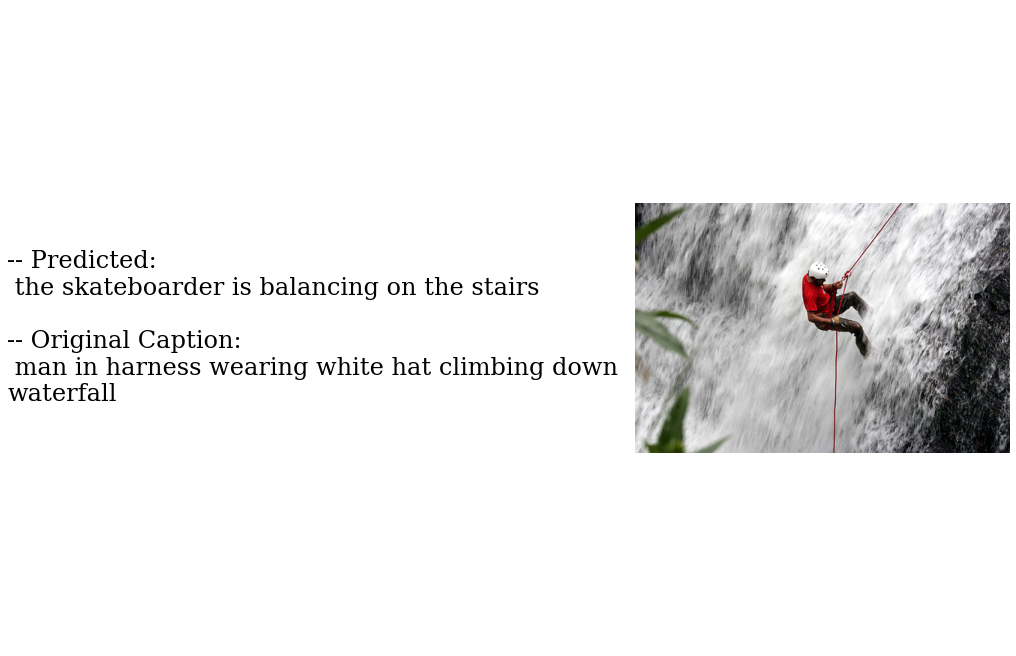

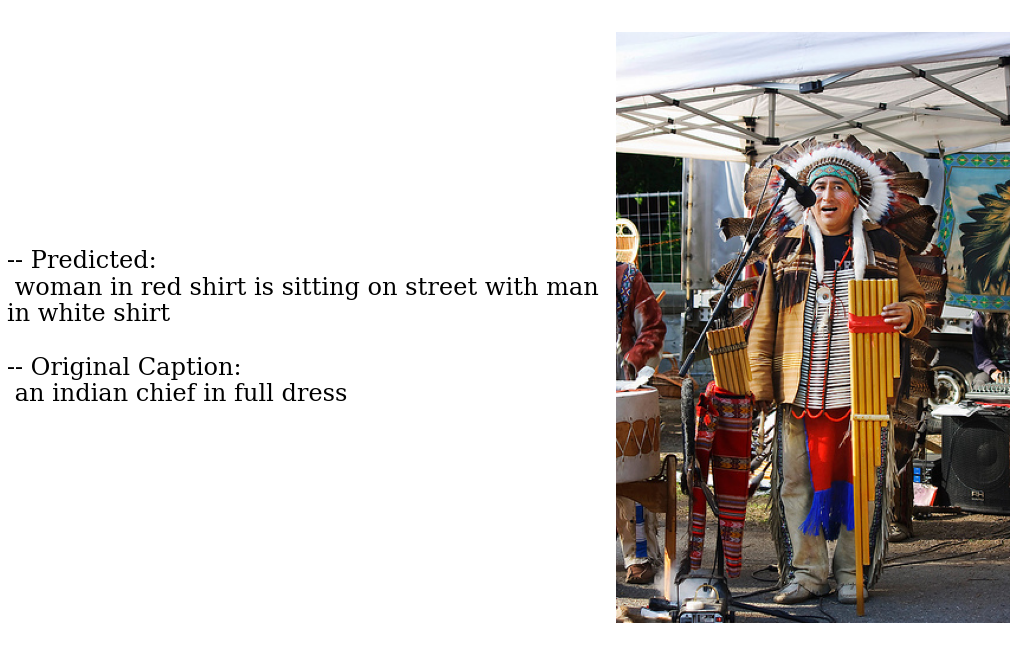

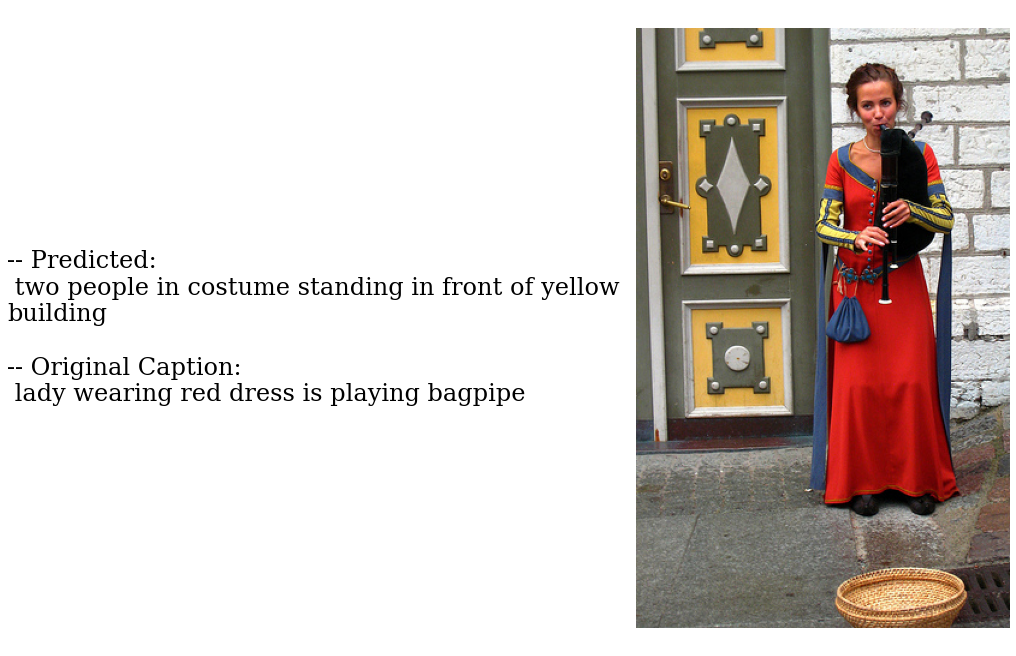

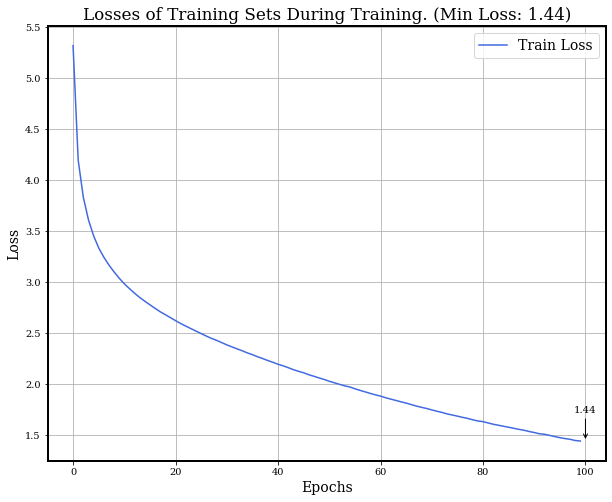

In [ ]:
load_info_and_visualize("part_a")

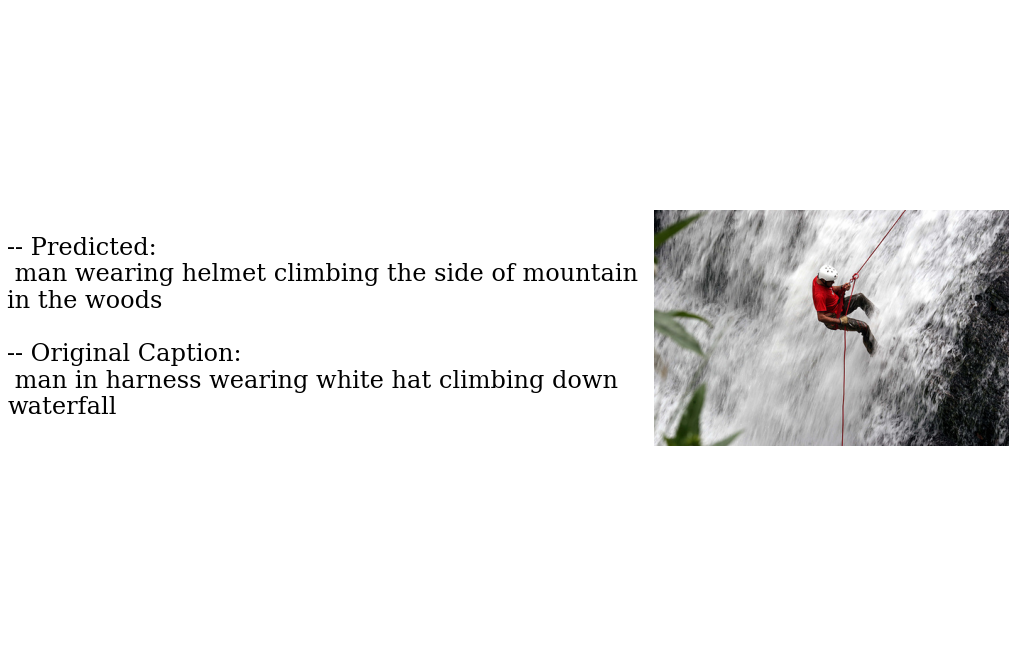

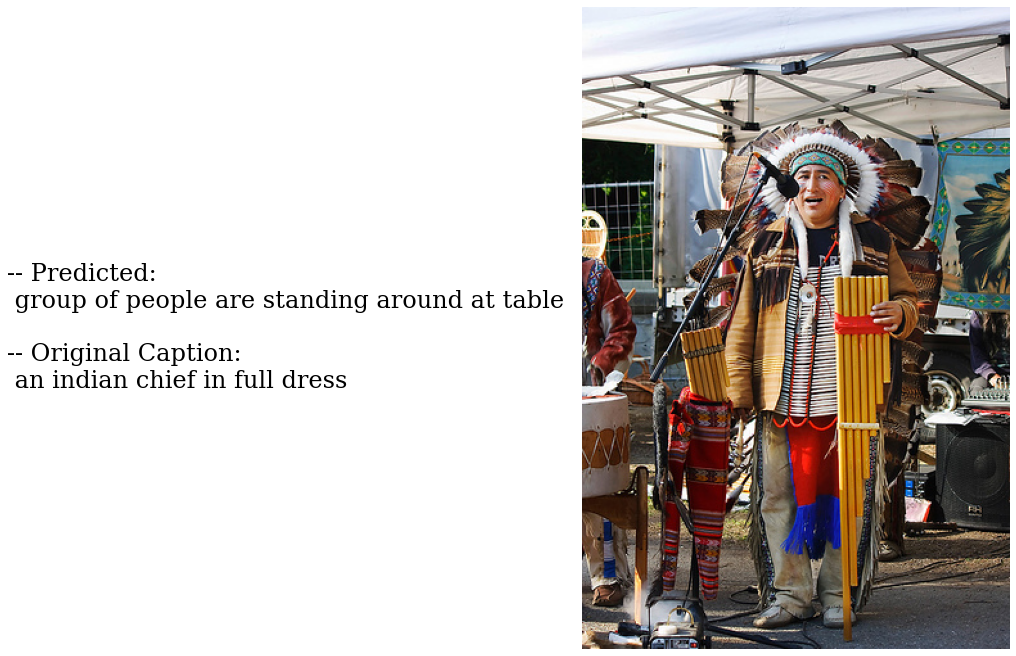

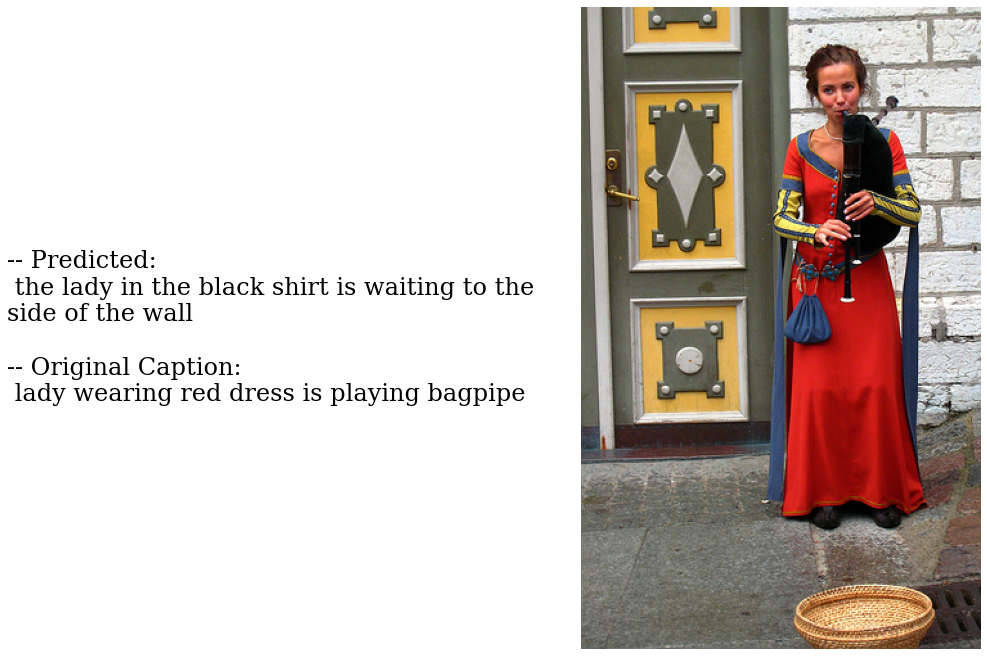

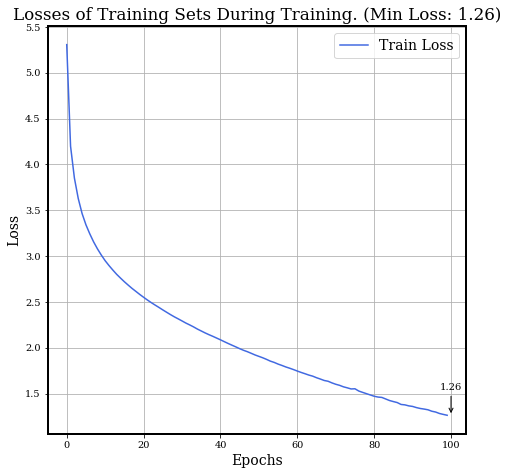

In [ ]:
load_info_and_visualize("part_b")

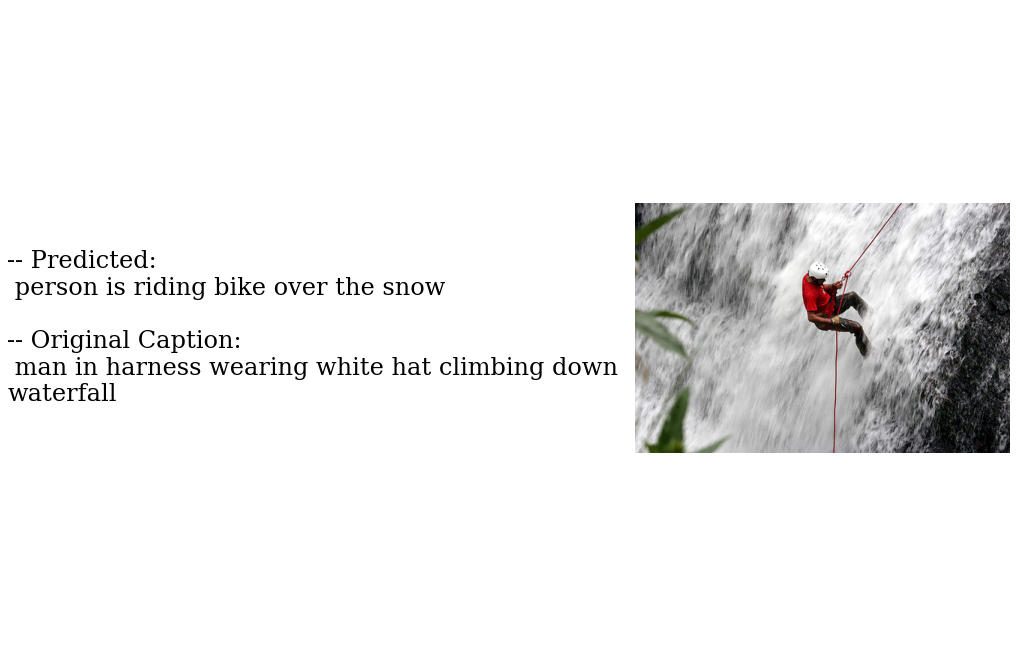

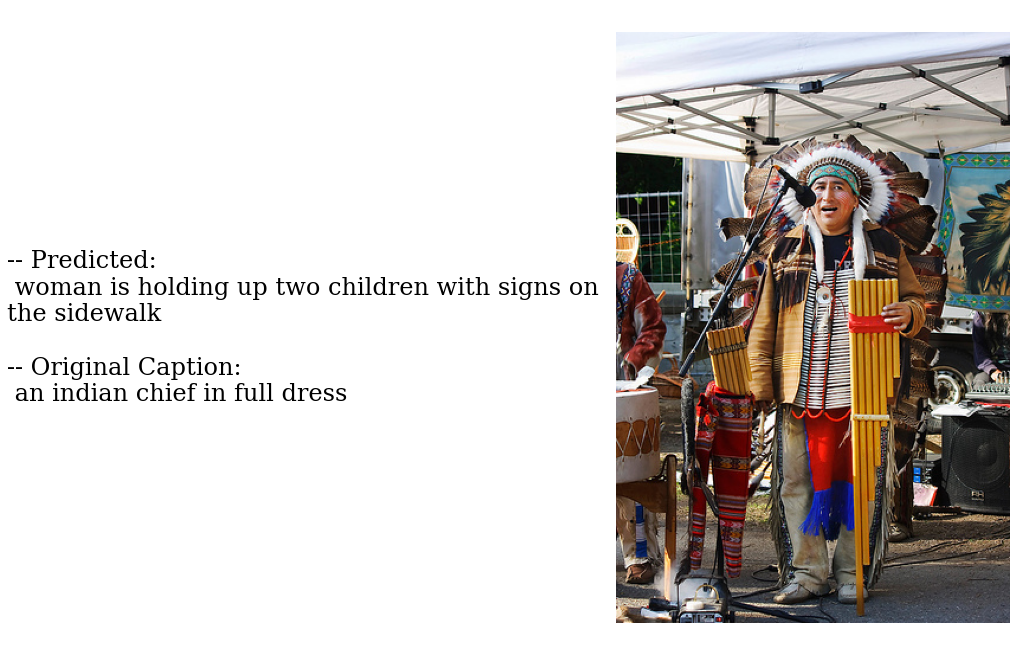

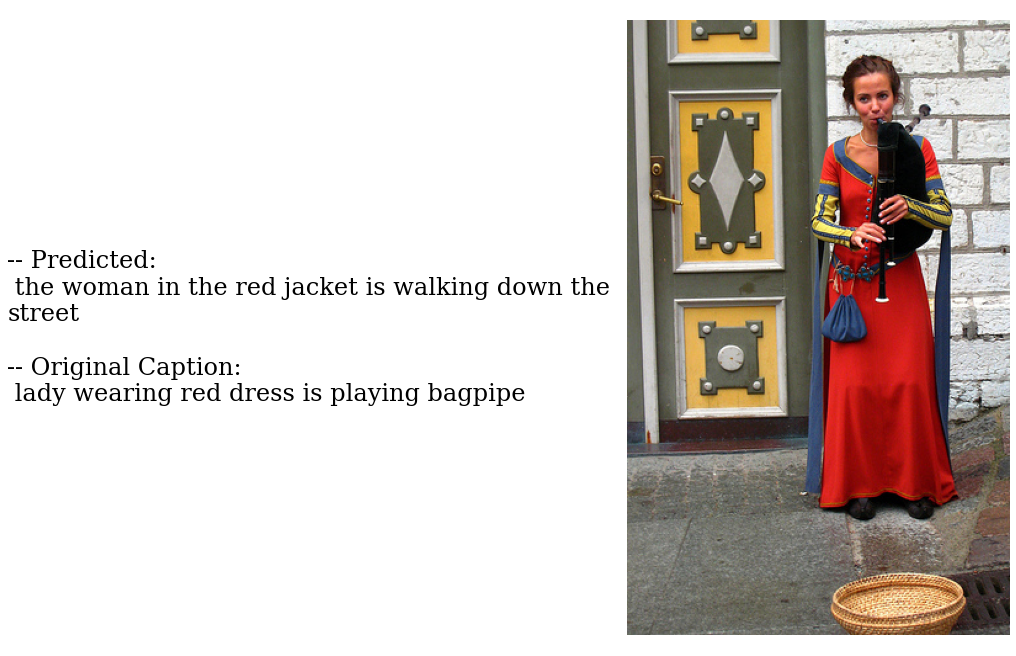

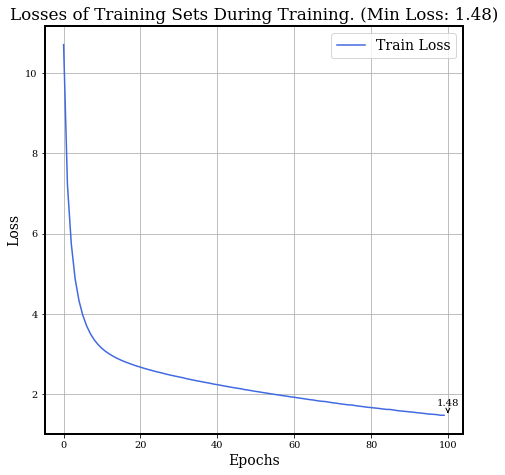

In [ ]:
load_info_and_visualize("part_c")

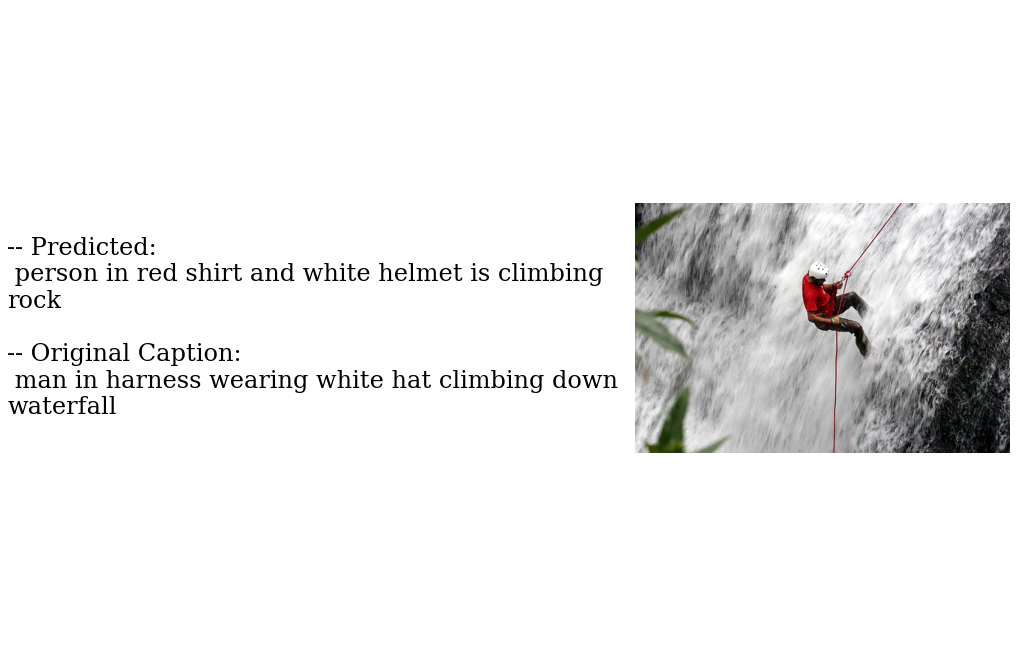

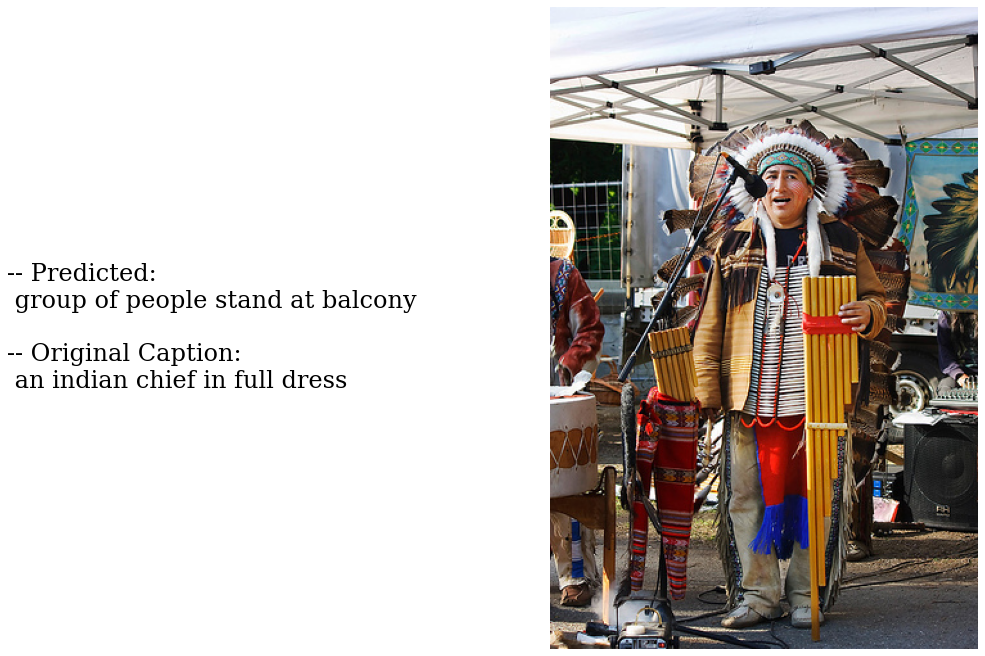

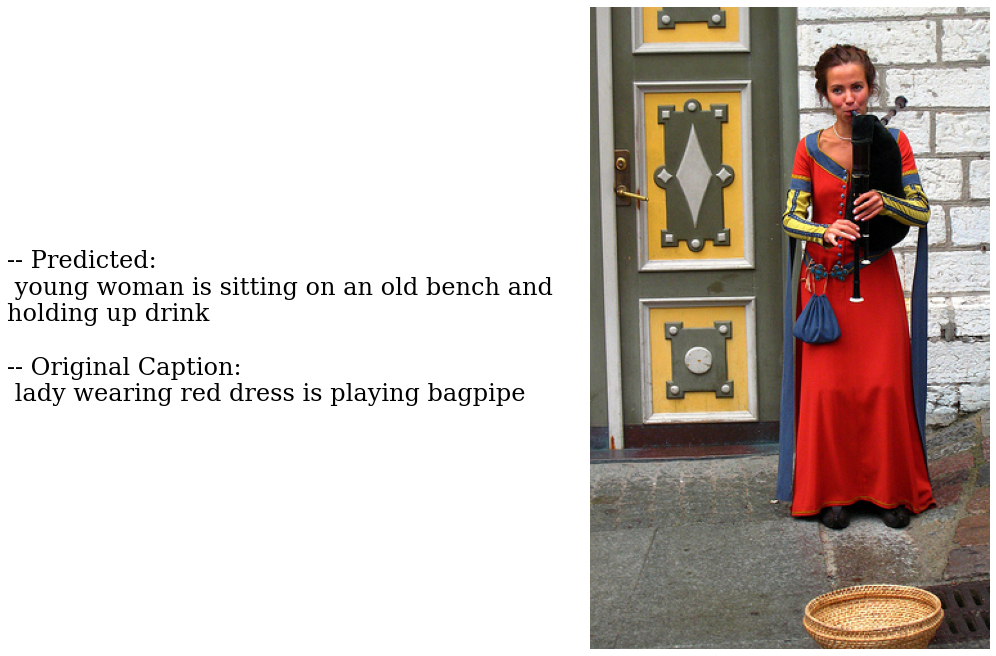

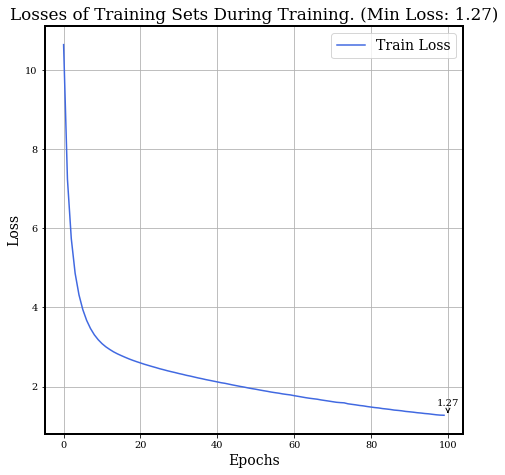

In [ ]:
load_info_and_visualize("part_d")